# Strategy 3 - Distinguish Predatory and General Conversations + Distinguish Predator and Victim

In [ ]:
!pip install transformers

In [2]:
from google.colab import drive
from config import *
from utils import *
from classification import *
from bert import *

from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import NearMiss
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3 as sqlite
import seaborn as sns
import torch

%matplotlib inline

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Increases the size limit of DataFrame columns
pd.set_option('display.max_colwidth', 500)

# Number of messages per conversation
CONVERSATION_SIZE = 24

# Folder to save results
RESULTS_FOLDER = RESULTS_PATH + 'Estrategia3/'

In [5]:
# Checking if GPU is available to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Using:', device)
print('CUDA available:', torch.cuda.is_available())
print('GPU:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else '-')

Using: cuda:0
CUDA available: True
GPU: Tesla P100-PCIE-16GB


**Connecting to SQLite**


In [6]:
connection = sqlite.connect('database.db')

print("Connection established!");

Connection established!


## Functions

In [7]:
def getDatasetInformationStep1(df):
  print('UPDATED DATASET INFORMATION')
  print('----------------------------------------------\n')

  print('Number of conversations: ', len(df['conversation_id'].value_counts()))
  print('-')

  dfPredatoryConversations = df[df['predatory_conversation'] == True]
  print('Number of predatory conversations: ', len(dfPredatoryConversations['conversation_id'].value_counts()))

In [8]:
def getDatasetInformationStep2(df):
  print('UPDATED DATASET INFORMATION')
  print('----------------------------------------------\n')

  print('Number of conversations: ', len(df['conversation_id'].value_counts()))
  print('Number of authors: ', len(df['author'].value_counts()))
  print('-')

  dfPredators = df[df['predator'] == True]
  print('Number of predatory conversations: ', len(dfPredators['conversation_id'].value_counts()))
  print('Number of sexual predators:', len(dfPredators['author'].value_counts())) 

In [9]:
def callClassifierStep1(algorithm, df, X, y, conversationSize, sample_indices_undersampling=[], splits=10, device='cpu', epochs=10, batch_size=32):
  if algorithm == "bert":
    indexes, metrics = classifyWithBERT(X, y, conversationSize, splits, device, epochs, batch_size)
  else:
    indexes, metrics = classify(algorithm, X, y, conversationSize, splits)

  predatoryConversations = []

  # Returns the ID of predatory conversations according to the index in the dataframe
  if len(sample_indices_undersampling):
    for i in indexes:
      predatoryConversations.append(df.loc[sample_indices_undersampling[i]]['conversation_id'])
  else: 
    for i in indexes:
      predatoryConversations.append(df.loc[i]['conversation_id'])

  # print('Number of predatory conversations: ' , len(predatoryConversations))
  # print(predatoryConversations)

  return indexes, metrics, predatoryConversations

In [10]:
def callClassifierStep2(algorithm, df, X, y, conversationSize, sample_indices_undersampling=[], splits=10, device='cpu', epochs=10, batch_size=32):
  if algorithm == "bert":
    indexes, metrics = classifyWithBERT(X, y, conversationSize, splits, device, epochs, batch_size)
  else:
    indexes, metrics = classify(algorithm, X, y, conversationSize, splits)

  predators = []

  # Returns the ID of predators according to the index in the dataframe
  if len(sample_indices_undersampling):
    for i in indexes:
      predators.append(df.loc[sample_indices_undersampling[i]]['author'])
  else:
    for i in indexes:
      predators.append(df.loc[i]['author'])

  # print('Number of sexual predators: ' , len(predators))
  # print(predators)

  return indexes, metrics, predators

In [11]:
def callTestClassifierStep1(algorithm, df, X_train, y_train, X_test, y_test, conversationSize, sample_indices_undersampling=[]):
  indexes, metrics = testClassify(algorithm, X_train, y_train, X_test, y_test, conversationSize)
  predatoryConversations = []

  # Returns the ID of predatory conversations according to the index in the dataframe
  if len(sample_indices_undersampling):
    for i in indexes:
      predatoryConversations.append(df.loc[sample_indices_undersampling[i]]['conversation_id'])
  else: 
    for i in indexes:
      predatoryConversations.append(df.loc[i]['conversation_id'])

  # print('Number of predatory conversations: ' , len(predatoryConversations))
  # print(predatoryConversations)

  return indexes, metrics, predatoryConversations

In [12]:
def callTestClassifierStep2(algorithm, df, X_train, y_train, X_test, y_test, conversationSize, sample_indices_undersampling=[]):
  indexes, metrics = testClassify(algorithm, X_train, y_train, X_test, y_test, conversationSize)
  predators = []

  # Returns the ID of predators according to the index in the dataframe
  if len(sample_indices_undersampling):
    for i in indexes:
      predators.append(df.loc[sample_indices_undersampling[i]]['author'])
  else:
    for i in indexes:
      predators.append(df.loc[i]['author'])

  #print('Number of sexual predators: ' , len(predators))
  #print(predators)
  
  return indexes, metrics, predators

## Step 1 - Distinguish Predatory and General Conversations

### Import preprocessed training dataset for strategy 1

In [13]:
dfBaseStep1 = pd.read_csv(DRIVE_PATH + 'databases/training_predatoryconversations_preprocessed.csv', sep=';', na_filter=False)

In [14]:
dfBaseStep1

,conversation_id,line,author,time,message,predatory_conversation
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,hola,False
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi,False
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up,False
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,False
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,False
...,...,...,...,...,...,...
873197,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok,True
873198,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,True
873199,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok,True
873200,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,True


In [15]:
# Saving dataframe in SQLite database
dfBaseStep1.to_sql('conversations_step1', connection, if_exists='replace', index=False)

### Group messages by conversations

In [16]:
dfGroupedMessagesStep1 = groupMessagesByConversations(connection, dfBaseStep1, CONVERSATION_SIZE)

In [17]:
dfGroupedMessagesStep1

,conversation_id,count_authors,messages,predatory_conversation
0,0000604306a283600b730276a2039471,3,b8810fee2f4a71f849f3f7409546d1d9 do you have any set of test cases for non conformant html5 a9b326df4e6da61c5b6f5e1058be83a2 there are some in the syntax module a9b326df4e6da61c5b6f5e1058be83a2 ive also used annes wf 2 0 tests but using those in the test harness in now broken as the spec stabilizes it makes sense to write more tests b8810fee2f4a71f849f3f7409546d1d9 btw do you have a good estimate of many man hours you have put into work on the conformance checker including hours of any other...,False
1,0001347c00d419eb537c0692e6e58eba,2,say asl and ill rip your heart out asl grr rips your heart out and eats it,False
2,000197b21283dc47810760e499d1f8ec,2,joint in my hand sorry im korea student marijuana can i see your boobs i m korea no can i see your boobs want to se emy dick i show you my dick if i see your boobs boobs,False
3,0002ee38ac5e78e7edbc4d4a556ec4b7,2,hey male or female australian male here hey i have question yes ask the question,False
4,000483300677468215a9e3b38728209b,2,if you have a channel with ports 1 and 2 and you try to send port2 down port1 it should obviously fail because the semantics of that are just crazy weird but if you send port1 down port1 should it also throw it would be equivalent to having a rope and throwing one end to the other end heres a channel pretty useless since why wouldnt you just create a new messagechannel for yourself i would guess most cases of port1 going down port1 will be mistakes so it makes sense to fail big at the point ...,False
...,...,...,...,...
66697,fffdb82e3d5078c7828024ac4855bffd,2,hi hi asl where are you from,False
66698,fffdd9142e809a7f634fbcc13063146d,2,hey asl u first p hi 20 m us u male too,False
66699,fffde018f39dafd4c8ef4ebaaadbec97,1,bugmail bug 14810 new first content model definition of canvas should get removed 1 transparent 2 transparent but if the but always applies,False
66700,ffff38287b6013960b9e96e08f85526a,2,hi asl hello kjlkj,False


In [18]:
# Saving dataframe in SQLite database
dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

### Delete conversations that doesn't have only 2 authors

**Data before deleting conversations**

In [19]:
getDatasetInformationStep1(dfGroupedMessagesStep1)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66702
-
Number of predatory conversations:  1972


**Deleting conversations that doesn't have only 2 authors**

In [20]:
# Number of conversations that doesn't have only 2 authors

query = '''SELECT conversation_id, count_authors
           FROM conversations_grouped_step1  
           WHERE count_authors <> 2 
           ORDER BY count_authors desc;'''

df = pd.read_sql(query, connection)

# Getting IDs of conversations that doesn't have only 2 authors
idConversations = df['conversation_id'].values
print('Number of conversations that doesn\'t have only 2 authors:', len(idConversations))

Number of conversations that doesn't have only 2 authors: 21100


In [21]:
# Delete tuples of conversations that doesn't have only 2 authors
query = '''DELETE FROM conversations_grouped_step1 WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))

c = connection.cursor()
c.execute(query, (idConversations))
connection.commit()

print("Total:", c.rowcount, "records deleted successfully!")

Total: 21100 records deleted successfully!


In [22]:
query = '''SELECT * FROM conversations_grouped_step1'''

dfGroupedMessagesStep1 = pd.read_sql(query, connection)
dfGroupedMessagesStep1.drop('count_authors', inplace=True, axis=1)
dfGroupedMessagesStep1.replace({'predatory_conversation': {0: False, 1: True}}, inplace=True)
dfGroupedMessagesStep1

,conversation_id,messages,predatory_conversation
0,0001347c00d419eb537c0692e6e58eba,say asl and ill rip your heart out asl grr rips your heart out and eats it,False
1,000197b21283dc47810760e499d1f8ec,joint in my hand sorry im korea student marijuana can i see your boobs i m korea no can i see your boobs want to se emy dick i show you my dick if i see your boobs boobs,False
2,0002ee38ac5e78e7edbc4d4a556ec4b7,hey male or female australian male here hey i have question yes ask the question,False
3,000483300677468215a9e3b38728209b,if you have a channel with ports 1 and 2 and you try to send port2 down port1 it should obviously fail because the semantics of that are just crazy weird but if you send port1 down port1 should it also throw it would be equivalent to having a rope and throwing one end to the other end heres a channel pretty useless since why wouldnt you just create a new messagechannel for yourself i would guess most cases of port1 going down port1 will be mistakes so it makes sense to fail big at the point ...,False
4,0004c07f0b5df631aa198dbfa33264bd,why did the chicken cross the road hiiz becuz he wanted to be a transexual unicorn nope to get to your house knock oh well isnt that stalkerish of him o very lol how are you not too bad hbu not bad at all just chilling at my friends house lol nicee xd mhmm asl 17 female canada you oh cool 17 f usa lol oh kewl xd yep so i have a question for a canadian shoot yall dont use freshman sophomore junior senior in high school sometimes but depending on where you are then no p ohh i always wondered p...,False
...,...,...,...
45597,fffd557228dac1e0f12bfb1237f37344,m19here 16 m usa u,False
45598,fffd7a8158eec142186df5f77e97a9b9,hi looking for a ripped sexy gay male r u him no,False
45599,fffdb82e3d5078c7828024ac4855bffd,hi hi asl where are you from,False
45600,fffdd9142e809a7f634fbcc13063146d,hey asl u first p hi 20 m us u male too,False


**Data after deleting conversations**

In [23]:
getDatasetInformationStep1(dfGroupedMessagesStep1)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  45602
-
Number of predatory conversations:  1087


**Number of words per conversation**

In [24]:
getConversationsWithMoreWords(dfGroupedMessagesStep1)

,conversation_id,words,messages
10779,3c98f24025742ea1d9ea8b3990071732,2003,hey read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems bega...
1194,06649fab7088fa8a4c58ccd27ac4d3d8,1412,computer sex the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of th...
27191,9862471a316571ab4bad3ae68cf72c5e,1104,hi hii your enthusiasm is offputting als 19 usa f where are you from how are you sad you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmo...
38377,d6c836f0eb4b27b86eabbd8b216331e1,1039,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be ...
20968,75fef10a08b0ce3b7cfc95348f9ae300,881,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
10175,392948cfa674493892902952449aef71,868,hey im 13 years old female and from the uk wbu x kill me while i molest you look like a i love piss you look like a fuck with me you like a foolish dancing your mom will love you look like a irish men never gonna fuck luigi you look like a please hurt me while i molest you look like a i love piss you never gonna fuck with me you look like a foolish nazi where i belong you look like a irish men never gonna fuck with me you look like a you disturb me while i molest you look like a i love penis...
5339,1e27624c3009e13ab708d46babf06fc7,791,stranger hi you stranger hey you im a horny girl please me you my name is anna stranger uhm sure stranger my names rei stranger nice to fuck you ok d you i would love that stranger how big are your tits you medium size stranger they can fit stranger im into kinky shit is that ok you yes d you i dont mind you i saw my sister fuck her bf and i got horny stranger wow youre one slutty chick you lol thanks d you also bi stranger thats extremely slutty stranger you be lovin my cock long time you a...
8420,2f38276c3766946553bf8e02a1470cca,785,you fucking americans are the biggest pervs on omegle freaking bigoted nigger go and suck your mums stinking anus or suck y

### Remove repeated words in sequence after grouping

In [25]:
i=0
for message in dfGroupedMessagesStep1['messages']:
  m = re.search(r'\b(.+)\s+\1\b', message)
  if m and m.group(0).strip():
    i=i+1
    #print(m.group(0))

print('Number of messages with some repeated word:', i)

Number of messages with some repeated word: 9913


In [26]:
# Store the messages before for later comparison
dfGroupedMessagesStep1['messages_before'] = dfGroupedMessagesStep1['messages']

dfGroupedMessagesStep1['messages'] = dfGroupedMessagesStep1['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))

In [27]:
# Saving dataframe in SQLite database
dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

**Comparing amount of words before and after removing repeated words**

In [28]:
df = dfGroupedMessagesStep1.copy()
df['words_before'] = df['messages_before'].str.count(' ') + 1
df['words_after'] = df['messages'].str.count(' ') + 1

df[['words_before', 'messages_before', 'words_after', 'messages']].sort_values(by=['words_before'], ascending = False).head(10)

,words_before,messages_before,words_after,messages
10779,2003,hey read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems bega...,2003,hey read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems bega...
1194,1412,computer sex the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of th...,1412,computer sex the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of th...
27191,1104,hi hii your enthusiasm is offputting als 19 usa f where are you from how are you sad you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmo...,1104,hi hii your enthusiasm is offputting als 19 usa f where are you from how are you sad you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmo...
38377,1039,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be ...,240,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying moii ooks suomest ficial messages from omegle will not be sent with the label stranger strangers cla

In [29]:
# Dropping column "messages_before"
dfGroupedMessagesStep1.drop('messages_before', inplace=True, axis=1)

**Number of words per conversation**

In [30]:
getConversationsWithMoreWords(dfGroupedMessagesStep1)

,conversation_id,words,messages
10779,3c98f24025742ea1d9ea8b3990071732,2003,hey read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems bega...
1194,06649fab7088fa8a4c58ccd27ac4d3d8,1412,computer sex the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of th...
27191,9862471a316571ab4bad3ae68cf72c5e,1104,hi hii your enthusiasm is offputting als 19 usa f where are you from how are you sad you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmo...
20968,75fef10a08b0ce3b7cfc95348f9ae300,881,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
5339,1e27624c3009e13ab708d46babf06fc7,791,stranger hi you stranger hey you im a horny girl please me you my name is anna stranger uhm sure stranger my names rei stranger nice to fuck you ok d you i would love that stranger how big are your tits you medium size stranger they can fit stranger im into kinky shit is that ok you yes d you i dont mind you i saw my sister fuck her bf and i got horny stranger wow youre one slutty chick you lol thanks d you also bi stranger thats extremely slutty stranger you be lovin my cock long time you a...
6845,268742179cf547cca6792731708c462e,708,hi want a car computer ipod x box etc for free just deposit 10 to my paypal account at my paypal id email and just email me your address at my id any random id nobody cares p anything of your wish hi you are our 10 thousand daily chatting stranger at omegle you have won a lottry prize of 10 000 to claim the prize just deposit 10 through your paypal account at this paypal id email and just email your address at this id any random id nobody cares p this money is been taken from you for securit...
1113,05f5b2119260313889c7b87d52bd1381,697,hi given the existence as uttered forth in the public works of puncher and wattmann of a personal god quaquaquaqua with white beard quaquaquaqua outside time without extension who from the heights of divine apathia divine athambia divine aphasia loves us dearly with some exceptions for reasons unknown but time will tell and suffers like the divine miranda with those who for reasons unknown but time will tell are plunged in torment plunged in fire whose fire flames if that continues and who c...
24332,88b4a0b1c954f4f43c835c32e2d756de,647,stranger i am lord voldemort you ok stranger what is your name you my name is karen and im a professional psychologist strang

### Feature extraction

#### Bag of Words

In [31]:
vectorizer = CountVectorizer(analyzer='word')
bagofwords = vectorizer.fit_transform(dfGroupedMessagesStep1['messages'])

In [32]:
bagofwords

<45602x50092 sparse matrix of type '<class 'numpy.int64'>'
	with 846214 stored elements in Compressed Sparse Row format>

In [33]:
# Separating X and Y

X = bagofwords
y = dfGroupedMessagesStep1['predatory_conversation']

[(False, 44515), (True, 1087)]
Dataset shape Counter({False: 44515, True: 1087})


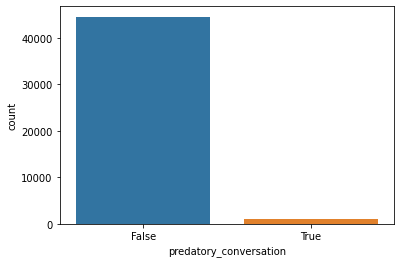

In [34]:
print(sorted(Counter(y).items()))
print('Dataset shape %s' % Counter(y))

ax = sns.countplot(x=y)

#### BERT

In [ ]:
# Tokenize messages

tokens = tokenizeMessagesBERT(dfGroupedMessagesStep1['messages'])

In [ ]:
# Generating embeddings

embeddings = generateEmbeddingsBERT(tokens)

In [ ]:
# Creating a dataframe with the embeddings

dfEmbeddingsBERT = pd.DataFrame(embeddings)
dfEmbeddingsBERT.info()

In [ ]:
# Saving embeddings

f = DRIVE_PATH + 'databases/training_predatoryconversations_embeddings_bert_{}messages.csv'.format(CONVERSATION_SIZE)
dfEmbeddingsBERT.to_csv(f, index=False, header=True, sep=';')

In [ ]:
# Separating X and Y

X = dfEmbeddingsBERT
y = dfGroupedMessagesStep1['predatory_conversation']

In [ ]:
print(sorted(Counter(y).items()))
print('Dataset shape %s' % Counter(y))

ax = sns.countplot(x=y)

### Imbalanced classification

In [35]:
# CLASSIFICATION - STEP 1 - DISTINGUISH PREDATORY AND GENERAL CONVERSATIONS

indexesNBM, metricsNBM, predatoryConversationsNBM = callClassifierStep1('naive_bayes_multinomial', dfGroupedMessagesStep1, X, y, CONVERSATION_SIZE)
indexesRF, metricsRF, predatoryConversationsRF = callClassifierStep1('random_forest', dfGroupedMessagesStep1, X, y, CONVERSATION_SIZE)
indexesKNN, metricsKNN, predatoryConversationsKNN = callClassifierStep1('knn', dfGroupedMessagesStep1, X, y, CONVERSATION_SIZE)
indexesSVM, metricsSVM, predatoryConversationsSVM = callClassifierStep1('svm', dfGroupedMessagesStep1, X, y, CONVERSATION_SIZE)
indexesNN, metricsNN, predatoryConversationsNN = callClassifierStep1('neural_network_mlp', dfGroupedMessagesStep1, X, y, CONVERSATION_SIZE)

**BERT**

In [ ]:
# Read embeddings
f = DRIVE_PATH + 'databases/training_predatoryconversations_embeddings_bert_{}messages.csv'.format(CONVERSATION_SIZE)
dfEmbeddingsBERT = pd.read_csv(f, sep=';')

X = dfEmbeddingsBERT
y = dfGroupedMessagesStep1['predatory_conversation']

In [ ]:
splits = 10
epochs = 50

# Defines the size of training and evaluation batches - 16 or 32
batch_size = 32

In [ ]:
indexesBERT, metricsBERT, predatoryConversationsBERT = callClassifierStep1('bert', dfGroupedMessagesStep1, X.values, y.values, CONVERSATION_SIZE, [], splits, device, epochs, batch_size)

### Balanced classification

**Balancing classes - Undersampling**

In [ ]:
nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

ax = sns.countplot(x=y_resampled)

In [ ]:
# CLASSIFICATION - STEP 1 - DISTINGUISH PREDATORY AND GENERAL CONVERSATIONS

indexesNBM, metricsNBM, predatoryConversationsNBM = callClassifierStep1('naive_bayes_multinomial', dfGroupedMessagesStep1, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesRF, metricsRF, predatoryConversationsRF = callClassifierStep1('random_forest', dfGroupedMessagesStep1, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesKNN, metricsKNN, predatoryConversationsKNN = callClassifierStep1('knn', dfGroupedMessagesStep1, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesSVM, metricsSVM, predatoryConversationsSVM = callClassifierStep1('svm', dfGroupedMessagesStep1, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesNN, metricsNN, predatoryConversationsNN = callClassifierStep1('neural_network_mlp', dfGroupedMessagesStep1, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)

**BERT**

In [ ]:
# Read embeddings
f = DRIVE_PATH + 'databases/training_predatoryconversations_embeddings_bert_{}messages.csv'.format(CONVERSATION_SIZE)
dfEmbeddingsBERT = pd.read_csv(f, sep=';')

X = dfEmbeddingsBERT
y = dfGroupedMessagesStep1['predatory_conversation']

In [ ]:
splits = 10
epochs = 50

# Defines the size of training and evaluation batches - 16 or 32
batch_size = 32

In [ ]:
nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

In [ ]:
indexesBERT, metricsBERT, predatoryConversationsBERT = callClassifierStep1('bert', dfGroupedMessagesStep1, X_resampled.values, y_resampled.values, CONVERSATION_SIZE, nm.sample_indices_, splits, device, epochs, batch_size)

## Step 2 - Distinguish Predator and Victim

### Choosing the best result from step 1

In [37]:
predatoryConversations = predatoryConversationsSVM 

print('Number of predatory conversations:', len(predatoryConversations))

Number of predatory conversations: 1038


### Import preprocessed training dataset for strategy 2

In [38]:
dfBaseStep2 = pd.read_csv(DRIVE_PATH + 'databases/training_predators_preprocessed.csv', sep=';', na_filter=False)

In [39]:
dfBaseStep2

,conversation_id,line,author,time,message,predator
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,hola,False
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi,False
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up,False
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,False
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,False
...,...,...,...,...,...,...
873197,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok,False
873198,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,True
873199,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok,False
873200,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,True


In [40]:
# Saving dataframe in SQLite database
dfBaseStep2.to_sql('conversations_step2', connection, if_exists='replace', index=False)

### Deleting conversations that were not classified as predatory by step 1

In [41]:
query = '''DELETE FROM conversations_step2 WHERE conversation_id not in (%s)''' % ','.join('?'*len(predatoryConversations))

c = connection.cursor()
c.execute(query, (predatoryConversations))
connection.commit()

print("Total:", c.rowcount, "records deleted successfully!")

Total: 801337 records deleted successfully!


In [42]:
query = '''SELECT * FROM conversations_step2'''

dfConversationsStep2 = pd.read_sql(query, connection)
dfConversationsStep2

,conversation_id,line,author,time,message,predator
0,fc77b9ed8d13697e8deea79de0b4df23,1,6f35a1f69fd4ae82056e4bc6a8a84575,23:56,hey,1
1,fc77b9ed8d13697e8deea79de0b4df23,2,5c5b806fbd1826340209616ddb9ed767,23:56,hi,0
2,fc77b9ed8d13697e8deea79de0b4df23,3,5c5b806fbd1826340209616ddb9ed767,23:57,how are you feeling,0
3,fc77b9ed8d13697e8deea79de0b4df23,4,6f35a1f69fd4ae82056e4bc6a8a84575,23:57,a little better what are u doing,1
4,fc77b9ed8d13697e8deea79de0b4df23,5,5c5b806fbd1826340209616ddb9ed767,23:57,i was just listening to some music,0
...,...,...,...,...,...,...
71860,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok,0
71861,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,1
71862,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok,0
71863,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,1


### Group messages by author

**Data before grouping**

In [43]:
getDatasetInformationStep2(dfConversationsStep2)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  1038
Number of authors:  476
-
Number of predatory conversations:  911
Number of sexual predators: 126


**Grouping**

In [44]:
dfGroupedMessagesStep2 = groupMessagesByAuthor(connection, dfConversationsStep2, CONVERSATION_SIZE)

In [45]:
dfGroupedMessagesStep2

,conversation_id,author,messages,predator
0,0014c1b4278df4bf8ea8a20b7abdb13c,970f6cbfa8b79242464120ec1bc7d074,hi how r ya was out with a buddy u miss me huh so is that a new pic cool wish u had a hot pic 2 c its ok that was a nice pic so how u getting to b up late oh my u rock sweety,True
1,0014c1b4278df4bf8ea8a20b7abdb13c,b03efd14f0f503f604facbdb66aa8065,hi where u been im cool k yeah been waiting 4 u lol just having fun umm lol sorry ty my dads out and stepbitch is asleep lol i do huh so we still on 4 tomorow,False
2,0027f42308aad202fcb7224597a7ac1a,980ffbae20a666d965bb171413352750,hey i took a shower just seeing if you had left yet oh lol i didnt know how long it would take how long will it take you take and take and go to ya go to and its on theres,False
3,0027f42308aad202fcb7224597a7ac1a,ca5496597b7151b9c2414c16c4ef5422,hey baby kool it wont take me two hours baby ok what was the name okay hold on i get off on ok is that a road ok then what,True
4,0063692c957229db0816e0f240d7fa0d,18253a7ec92823c10255f80e57f88e74,hello a little late but i am here so what are you up to just surfing the net any one on it good so tell me what do you like doing for fun i figured that much you ever hooked up with anybody from the net before many people your going to be the 2nd one i have met some bi sexual chick from santa cruz about 3 years ogo when we first got together we just jumped straight into bed and were only fuck buddies for about 1 and a half years she was all right had real long hair that went past her ass whe...,True
...,...,...,...,...
2071,ff831530631155876374c049724fa832,c62283536cf6261e5ffbcb323c8a2571,hi o foxy picture what a doll i am not siily no i not i crazy im watching bad boys i am crazy in love with you lol what are you going to do tomorrow o ok are you watching tv have you been watching it today,True
2072,ffd55257c660e70e17cd38834037a46c,81383171ca9da4d245dea449027c3d09,how are you im good missed you too what are you up to im here now working on my kids computer that i made them yeah its much faster than the last one i made still needs a little work but thats what i do so what did you do all day anything fun,True
2073,ffd55257c660e70e17cd38834037a46c,931ec03eeee8c0899a03830bc14879fb,heya good u good i missed u hugs nutin hoping u wuld b on kewl ah they like it good skewl not realy same old,False
2074,fff6daff608e7b65936e42279bf0e13d,0da31bd56f003f3466804bdc021c1e7a,just saying hi even tho ur not online oh ok nothin really u and ur questions u should ask me a question umm nope havent seen that picture i like alot of much p haha i doubt it,False


In [46]:
# Saving dataframe in SQLite database
dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)

**Data after grouping**

In [47]:
getDatasetInformationStep2(dfGroupedMessagesStep2)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  1038
Number of authors:  468
-
Number of predatory conversations:  911
Number of sexual predators: 126


**Number of words per conversation**

In [48]:
getConversationsWithMoreWords(dfGroupedMessagesStep2)

,conversation_id,words,messages
994,75fef10a08b0ce3b7cfc95348f9ae300,877,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
323,268742179cf547cca6792731708c462e,707,hi want a car computer ipod x box etc for free just deposit 10 to my paypal account at my paypal id email and just email me your address at my id any random id nobody cares p anything of your wish hi you are our 10 thousand daily chatting stranger at omegle you have won a lottry prize of 10 000 to claim the prize just deposit 10 through your paypal account at this paypal id email and just email your address at this id any random id nobody cares p this money is been taken from you for securit...
717,53a7151ce50d3c952ce0cf254007e7b5,350,hey there i was again tonight forcing laughter faking smiles same old tired lonely place walls of insincerity shifiting eyes and vancancy vanished when i saw your face all i can say is it was enchanting to meet you your eyes whispered have we met across the room your silhouette starts to make its way to me the playful conversation starts counter all your quick remarks like passing notes in secrecy and it was enchanting to meet you all i can say is i was enchanted to meet you this night is sp...
503,3a1c2ea1ad03195fe18eef18afce5203,261,come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked v co...
916,6dd3d49739a9694a2505fe99846cddcc,198,69b0d3dfe919a6b860a9fac82de52a7e other browsers make the bullets overlap the floats 69b0d3dfe919a6b860a9fac82de52a7e the bullet is always displaced from the first line by border padding 69b0d3dfe919a6b860a9fac82de52a7e but the line isnt moved to compensate 69b0d3dfe919a6b860a9fac82de52a7e see also the three messages i just sent to ww style about float displace 69b0d3dfe919a6b860a9fac82de52a7e no they overlap a left float theyre a fixed distance border padding of the list item from the right ...
1826,e025a1c7a3424c27c91a5a383f0e52ca,187,u never said nothin like i sat 4 like long time u coulda said like do somethin is ok i gave up and went 2 the union omg i love it here told my grandma i gotta use the library cuz like cant find what i need on line so took my back pack and went and hung out there like tons of hot guys i got a fone number and like he wants me to come to his frat party 2nite he like asked me out it was so kewl k like a guy on here told me u just sit in the place by the fire place and tht is the gay spot so i di...
810,60b604ac7468ad2a6051455516b29b03,181,no package x11 found no package kbproto found consider adjusting the pkg config path environment variable if you installed software in a non standard prefix alternatively you may set the environment variables xt cflags and xt libs to avoid the need to call pkg config see the pkg config man page for more details please attach the following file when filing a report to bugs gentoo org var tmp portage libxt 1 0 2 work libxt 1 0 2 config log error x11 libs libxt 1 0 2 failed call stack ebuild sh...
651,4eaa173dde98f33617c86d880db5bc3e,177,hey luv i was hoping 2 talk 2 u at night i really want 2 talk 2 u and tell u some of bad news that happen at the hospital and i glad u didn

### Remove repeated words in sequence after grouping

In [49]:
i=0
for message in dfGroupedMessagesStep2['messages']:
  m = re.search(r'\b(.+)\s+\1\b', message)
  if m and m.group(0).strip():
    i=i+1
    #print(m.group(0))

print('Number of messages with some repeated word:', i)

Number of messages with some repeated word: 282


In [50]:
# Store the messages before for later comparison
dfGroupedMessagesStep2['messages_before'] = dfGroupedMessagesStep2['messages']

dfGroupedMessagesStep2['messages'] = dfGroupedMessagesStep2['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))

In [51]:
# Saving dataframe in SQLite database
dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)

**Comparing amount of words before and after removing repeated words**

In [52]:
df = dfGroupedMessagesStep2.copy()
df['words_before'] = df['messages_before'].str.count(' ') + 1
df['words_after'] = df['messages'].str.count(' ') + 1

df[['words_before', 'messages_before', 'words_after', 'messages']].sort_values(by=['words_before'], ascending = False).head(10)

,words_before,messages_before,words_after,messages
994,877,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...,877,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
323,707,hi want a car computer ipod x box etc for free just deposit 10 to my paypal account at my paypal id email and just email me your address at my id any random id nobody cares p anything of your wish hi you are our 10 thousand daily chatting stranger at omegle you have won a lottry prize of 10 000 to claim the prize just deposit 10 through your paypal account at this paypal id email and just email your address at this id any random id nobody cares p this money is been taken from you for securit...,707,hi want a car computer ipod x box etc for free just deposit 10 to my paypal account at my paypal id email and just email me your address at my id any random id nobody cares p anything of your wish hi you are our 10 thousand daily chatting stranger at omegle you have won a lottry prize of 10 000 to claim the prize just deposit 10 through your paypal account at this paypal id email and just email your address at this id any random id nobody cares p this money is been taken from you for securit...
717,350,hey there i was again tonight forcing laughter faking smiles same old tired lonely place walls of insincerity shifiting eyes and vancancy vanished when i saw your face all i can say is it was enchanting to meet you your eyes whispered have we met across the room your silhouette starts to make its way to me the playful conversation starts counter all your quick remarks like passing notes in secrecy and it was enchanting to meet you all i can say is i was enchanted to meet you this night is sp...,350,hey there i was again tonight forcing laughter faking smiles same old tired lonely place walls of insincerity shifiting eyes and vancancy vanished when i saw your face all i can say is it was enchanting to meet you your eyes whispered have we met across the room your silhouette starts to make its way to me the playful conversation starts counter all your quick remarks like passing notes in secrecy and it was enchanting to meet you all i can say is i was enchanted to meet you this night is sp...
503,261,come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked come see my ballsack on it leave a comment on my channel saying you want me naked v co...,37,come see my ballsack on it leave a comment on my channel saying you want me naked v come see my ballsack on it leave a comment on my channel saying you want me naked lol wut
916,198,69b0d3dfe919a6b860a9fac82de52a7e other browsers make the bullets overlap the floats 69b0d3dfe919a6b860a9fac82de52a7e the bullet is always displaced from the first line by border padding 69b0d3dfe919a6b860a9fac82de52a7e b

In [53]:
# Dropping column "messages_before"
dfGroupedMessagesStep2.drop('messages_before', inplace=True, axis=1)

**Number of words per conversation**

In [54]:
getConversationsWithMoreWords(dfGroupedMessagesStep2)

,conversation_id,words,messages
994,75fef10a08b0ce3b7cfc95348f9ae300,877,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
323,268742179cf547cca6792731708c462e,707,hi want a car computer ipod x box etc for free just deposit 10 to my paypal account at my paypal id email and just email me your address at my id any random id nobody cares p anything of your wish hi you are our 10 thousand daily chatting stranger at omegle you have won a lottry prize of 10 000 to claim the prize just deposit 10 through your paypal account at this paypal id email and just email your address at this id any random id nobody cares p this money is been taken from you for securit...
717,53a7151ce50d3c952ce0cf254007e7b5,350,hey there i was again tonight forcing laughter faking smiles same old tired lonely place walls of insincerity shifiting eyes and vancancy vanished when i saw your face all i can say is it was enchanting to meet you your eyes whispered have we met across the room your silhouette starts to make its way to me the playful conversation starts counter all your quick remarks like passing notes in secrecy and it was enchanting to meet you all i can say is i was enchanted to meet you this night is sp...
916,6dd3d49739a9694a2505fe99846cddcc,198,69b0d3dfe919a6b860a9fac82de52a7e other browsers make the bullets overlap the floats 69b0d3dfe919a6b860a9fac82de52a7e the bullet is always displaced from the first line by border padding 69b0d3dfe919a6b860a9fac82de52a7e but the line isnt moved to compensate 69b0d3dfe919a6b860a9fac82de52a7e see also the three messages i just sent to ww style about float displace 69b0d3dfe919a6b860a9fac82de52a7e no they overlap a left float theyre a fixed distance border padding of the list item from the right ...
1826,e025a1c7a3424c27c91a5a383f0e52ca,187,u never said nothin like i sat 4 like long time u coulda said like do somethin is ok i gave up and went 2 the union omg i love it here told my grandma i gotta use the library cuz like cant find what i need on line so took my back pack and went and hung out there like tons of hot guys i got a fone number and like he wants me to come to his frat party 2nite he like asked me out it was so kewl k like a guy on here told me u just sit in the place by the fire place and tht is the gay spot so i di...
810,60b604ac7468ad2a6051455516b29b03,181,no package x11 found no package kbproto found consider adjusting the pkg config path environment variable if you installed software in a non standard prefix alternatively you may set the environment variables xt cflags and xt libs to avoid the need to call pkg config see the pkg config man page for more details please attach the following file when filing a report to bugs gentoo org var tmp portage libxt 1 0 2 work libxt 1 0 2 config log error x11 libs libxt 1 0 2 failed call stack ebuild sh...
651,4eaa173dde98f33617c86d880db5bc3e,177,hey luv i was hoping 2 talk 2 u at night i really want 2 talk 2 u and tell u some of bad news that happen at the hospital and i glad u didnt get into trouble or anything like that at least 1 thing can take that is good from this day if u cant b on here can u and i dont stop write im back and forth i would love that unless u seeing another guy lol i check a couple more times just in case u r on i hope u know that u have my heart hope talk u soon i love u your love hunny ty hi it i sok did u g...
1254,9563e3b1a52630a00486a03402947ae9,170,hey there im glad u came on did u get my off line message i did map quest and got directions but now i cant find them i just need the addy

### Feature extraction

#### Bag of Words

In [55]:
vectorizer = CountVectorizer(analyzer='word')
bagofwords = vectorizer.fit_transform(dfGroupedMessagesStep2['messages'])

In [56]:
bagofwords

<2076x6211 sparse matrix of type '<class 'numpy.int64'>'
	with 65673 stored elements in Compressed Sparse Row format>

In [57]:
# Separating X and Y
X = bagofwords
y = dfGroupedMessagesStep2['predator']

[(False, 1165), (True, 911)]
Dataset shape Counter({False: 1165, True: 911})


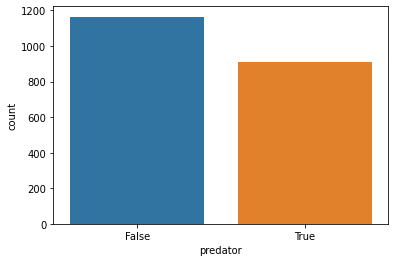

In [58]:
print(sorted(Counter(y).items()))
print('Dataset shape %s' % Counter(y))

ax = sns.countplot(x=y)

#### BERT

In [ ]:
# Tokenize messages

tokens = tokenizeMessagesBERT(dfGroupedMessagesStep2['messages'])

In [ ]:
# Generating embeddings

embeddings = generateEmbeddingsBERT(tokens)

In [ ]:
# Creating a dataframe with the embeddings

dfEmbeddingsBERT = pd.DataFrame(embeddings)
dfEmbeddingsBERT.info()

In [ ]:
# Separating X and Y

X = dfEmbeddingsBERT
y = dfGroupedMessagesStep2['predator']

In [ ]:
print(sorted(Counter(y).items()))
print('Dataset shape %s' % Counter(y))

ax = sns.countplot(x=y)

### Imbalanced classification

In [59]:
# CLASSIFICATION - STEP 2 - DISTINGUISH PREDATOR AND VICTIM

indexesNBM, metricsNBM, predatorsNBM = callClassifierStep2('naive_bayes_multinomial', dfGroupedMessagesStep2, X, y, CONVERSATION_SIZE)
indexesRF, metricsRF, predatorsRF = callClassifierStep2('random_forest', dfGroupedMessagesStep2, X, y, CONVERSATION_SIZE)
indexesKNN, metricsKNN, predatorsKNN = callClassifierStep2('knn', dfGroupedMessagesStep2, X, y, CONVERSATION_SIZE)
indexesSVM, metricsSVM, predatorsSVM = callClassifierStep2('svm', dfGroupedMessagesStep2, X, y, CONVERSATION_SIZE)
indexesNN, metricsNN, predatorsNN = callClassifierStep2('neural_network_mlp', dfGroupedMessagesStep2, X, y, CONVERSATION_SIZE)

**BERT**

In [60]:
splits = 10
epochs = 50

# Defines the size of training and evaluation batches - 16 or 32
batch_size = 32

In [ ]:
tokens = tokenizeMessagesBERT(dfGroupedMessagesStep2['messages'])
embeddings = generateEmbeddingsBERT(tokens)
dfEmbeddingsBERT = pd.DataFrame(embeddings)

X = dfEmbeddingsBERT
y = dfGroupedMessagesStep2['predator']

In [ ]:
indexesBERT, metricsBERT, predatorsBERT = callClassifierStep2('bert', dfGroupedMessagesStep2, X.values, y.values, CONVERSATION_SIZE, [], splits, device, epochs, batch_size)

### Balanced classification

**Balancing classes - Undersampling**

In [ ]:
nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

ax = sns.countplot(x=y_resampled)

In [ ]:
# CLASSIFICATION - STEP 2 - DISTINGUISH PREDATOR AND VICTIM

indexesNBM, metricsNBM, predatorsNBM = callClassifierStep2('naive_bayes_multinomial', dfGroupedMessagesStep2, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesRF, metricsRF, predatorsRF = callClassifierStep2('random_forest', dfGroupedMessagesStep2, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesKNN, metricsKNN, predatorsKNN = callClassifierStep2('knn', dfGroupedMessagesStep2, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesSVM, metricsSVM, predatorsSVM = callClassifierStep2('svm', dfGroupedMessagesStep2, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesNN, metricsNN, predatorsNN = callClassifierStep2('neural_network_mlp', dfGroupedMessagesStep2, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)

**BERT**

In [ ]:
splits = 10
epochs = 50

# Defines the size of training and evaluation batches - 16 or 32
batch_size = 32

In [ ]:
tokens = tokenizeMessagesBERT(dfGroupedMessagesStep2['messages'])
embeddings = generateEmbeddingsBERT(tokens)
dfEmbeddingsBERT = pd.DataFrame(embeddings)

X = dfEmbeddingsBERT
y = dfGroupedMessagesStep2['predator']

nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

In [ ]:
indexesBERT, metricsBERT, predatorsBERT = callClassifierStep2('bert', dfGroupedMessagesStep2, X_resampled.values, y_resampled.values, CONVERSATION_SIZE, nm.sample_indices_, splits, device, epochs, batch_size)

### Visualizing conversations

**Naive Bayes Multinomial**

In [63]:
dfGroupedMessagesStep2[dfGroupedMessagesStep2.index.isin(indexesNBM)]

,conversation_id,author,messages,predator
0,0014c1b4278df4bf8ea8a20b7abdb13c,970f6cbfa8b79242464120ec1bc7d074,hi how r ya was out with a buddy u miss me huh so is that a new pic cool wish u had a hot pic 2 c its ok that was a nice pic so how u getting to b up late oh my u rock sweety,True
2,0027f42308aad202fcb7224597a7ac1a,980ffbae20a666d965bb171413352750,hey i took a shower just seeing if you had left yet oh lol i didnt know how long it would take how long will it take you take and go to ya go to and its on theres,False
3,0027f42308aad202fcb7224597a7ac1a,ca5496597b7151b9c2414c16c4ef5422,hey baby kool it wont take me two hours baby ok what was the name okay hold on i get off on ok is that a road ok then what,True
4,0063692c957229db0816e0f240d7fa0d,18253a7ec92823c10255f80e57f88e74,hello a little late but i am here so what are you up to just surfing the net any one on it good so tell me what do you like doing for fun i figured that much you ever hooked up with anybody from the net before many people your going to be the 2nd one i have met some bi sexual chick from santa cruz about 3 years ogo when we first got together we just jumped straight into bed and were only fuck buddies for about 1 and a half years she was all right had real long hair that went past her ass whe...,True
7,012cd762a7e0a20819d99bafc66b12a2,aebe7a87ad50fbad92d9931c49cae848,hey how are you sweety ohh no wanna call me ohh no aww call me still got the number darn sweety wish i could come help any gingerala ok,True
...,...,...,...,...
2068,ff7209270cec8b957f4bc2318b164921,23bffbccce4e395053495c68a5e15b68,hey u hung up on me u gonna call me back try didnt you like talking to me and so did u sounded sweet and sexy when u call me back no it isnt we didnt even talk 5 minutes i will take ya to buy another one so dont worry about that i dont even know where you live though when u call me back,True
2071,ff831530631155876374c049724fa832,c62283536cf6261e5ffbcb323c8a2571,hi o foxy picture what a doll i am not siily no i not i crazy im watching bad boys i am crazy in love with you lol what are you going to do tomorrow o ok are you watching tv have you been watching it today,True
2072,ffd55257c660e70e17cd38834037a46c,81383171ca9da4d245dea449027c3d09,how are you im good missed you too what are you up to im here now working on my kids computer that i made them yeah its much faster than the last one i made still needs a little work but thats what i do so what did you do all day anything fun,True
2074,fff6daff608e7b65936e42279bf0e13d,0da31bd56f003f3466804bdc021c1e7a,just saying hi even tho ur not online oh ok nothin really u and ur questions u should ask me a question umm nope havent seen that picture i like alot of much p haha i doubt it,False


**Random Forest**

In [64]:
dfGroupedMessagesStep2[dfGroupedMessagesStep2.index.isin(indexesRF)]

,conversation_id,author,messages,predator
0,0014c1b4278df4bf8ea8a20b7abdb13c,970f6cbfa8b79242464120ec1bc7d074,hi how r ya was out with a buddy u miss me huh so is that a new pic cool wish u had a hot pic 2 c its ok that was a nice pic so how u getting to b up late oh my u rock sweety,True
2,0027f42308aad202fcb7224597a7ac1a,980ffbae20a666d965bb171413352750,hey i took a shower just seeing if you had left yet oh lol i didnt know how long it would take how long will it take you take and go to ya go to and its on theres,False
3,0027f42308aad202fcb7224597a7ac1a,ca5496597b7151b9c2414c16c4ef5422,hey baby kool it wont take me two hours baby ok what was the name okay hold on i get off on ok is that a road ok then what,True
4,0063692c957229db0816e0f240d7fa0d,18253a7ec92823c10255f80e57f88e74,hello a little late but i am here so what are you up to just surfing the net any one on it good so tell me what do you like doing for fun i figured that much you ever hooked up with anybody from the net before many people your going to be the 2nd one i have met some bi sexual chick from santa cruz about 3 years ogo when we first got together we just jumped straight into bed and were only fuck buddies for about 1 and a half years she was all right had real long hair that went past her ass whe...,True
9,01956b8f45560d2d44d594f36a66f526,af7a0adebf50023598764bdaf2080be4,hey sexy how are you what have you been up to awe no i am sorry do you want me to come make you feel better awe well that could be yeah i would like to come see you well of course i want to what would you want to do p i can think of a lot of things maybe,True
...,...,...,...,...
2067,feeecf337e3b25d7f9bb0ef135e3ad74,0599cd3f7fc15849844468b0702ff593,how are you i am still alive tell me where have you been i missed you ok any sexual experience i understand you very cold ok good where are you at good,True
2068,ff7209270cec8b957f4bc2318b164921,23bffbccce4e395053495c68a5e15b68,hey u hung up on me u gonna call me back try didnt you like talking to me and so did u sounded sweet and sexy when u call me back no it isnt we didnt even talk 5 minutes i will take ya to buy another one so dont worry about that i dont even know where you live though when u call me back,True
2070,ff831530631155876374c049724fa832,adb9f96249398e78741e5451e6d635ca,hi your funny yes you are silly your not crazy aww still helping my grandma not now no,False
2071,ff831530631155876374c049724fa832,c62283536cf6261e5ffbcb323c8a2571,hi o foxy picture what a doll i am not siily no i not i crazy im watching bad boys i am crazy in love with you lol what are you going to do tomorrow o ok are you watching tv have you been watching it today,True


**KNN**

In [65]:
dfGroupedMessagesStep2[dfGroupedMessagesStep2.index.isin(indexesKNN)]

,conversation_id,author,messages,predator
2,0027f42308aad202fcb7224597a7ac1a,980ffbae20a666d965bb171413352750,hey i took a shower just seeing if you had left yet oh lol i didnt know how long it would take how long will it take you take and go to ya go to and its on theres,False
4,0063692c957229db0816e0f240d7fa0d,18253a7ec92823c10255f80e57f88e74,hello a little late but i am here so what are you up to just surfing the net any one on it good so tell me what do you like doing for fun i figured that much you ever hooked up with anybody from the net before many people your going to be the 2nd one i have met some bi sexual chick from santa cruz about 3 years ogo when we first got together we just jumped straight into bed and were only fuck buddies for about 1 and a half years she was all right had real long hair that went past her ass whe...,True
5,0063692c957229db0816e0f240d7fa0d,1ab138af02c1f79eefb73cafafd078f8,hey yea i wuz watching american idol yea ll kewl j party lol yea no who elsedid u meet lol wuz she hot wut happend,False
7,012cd762a7e0a20819d99bafc66b12a2,aebe7a87ad50fbad92d9931c49cae848,hey how are you sweety ohh no wanna call me ohh no aww call me still got the number darn sweety wish i could come help any gingerala ok,True
9,01956b8f45560d2d44d594f36a66f526,af7a0adebf50023598764bdaf2080be4,hey sexy how are you what have you been up to awe no i am sorry do you want me to come make you feel better awe well that could be yeah i would like to come see you well of course i want to what would you want to do p i can think of a lot of things maybe,True
...,...,...,...,...
2064,fe7bdb47bf11ac2e64d7ed776b51cc8f,b679fca2e3690b4d3c60815edf4e3ca5,youre alive s and still on i hope like recently i saw you were on a few times but never answered me i thought you were mad at me and it bwoke my widdle heart x ahh i wuz feelin bad then ignore my last note to you on myspace well im sorry i was so overly sensitive i saw you checked in for a few minutes every once in a while now it makes sense you probably were using somebody elses puter and just had time to pick up your messages i missed ya ok so i wont ever get paranoid again k so what u bee...,True
2067,feeecf337e3b25d7f9bb0ef135e3ad74,0599cd3f7fc15849844468b0702ff593,how are you i am still alive tell me where have you been i missed you ok any sexual experience i understand you very cold ok good where are you at good,True
2068,ff7209270cec8b957f4bc2318b164921,23bffbccce4e395053495c68a5e15b68,hey u hung up on me u gonna call me back try didnt you like talking to me and so did u sounded sweet and sexy when u call me back no it isnt we didnt even talk 5 minutes i will take ya to buy another one so dont worry about that i dont even know where you live though when u call me back,True
2070,ff831530631155876374c049724fa832,adb9f96249398e78741e5451e6d635ca,hi your funny yes you are silly your not crazy aww still helping my grandma not now no,False


**SVM**

In [66]:
dfGroupedMessagesStep2[dfGroupedMessagesStep2.index.isin(indexesSVM)]

,conversation_id,author,messages,predator
0,0014c1b4278df4bf8ea8a20b7abdb13c,970f6cbfa8b79242464120ec1bc7d074,hi how r ya was out with a buddy u miss me huh so is that a new pic cool wish u had a hot pic 2 c its ok that was a nice pic so how u getting to b up late oh my u rock sweety,True
2,0027f42308aad202fcb7224597a7ac1a,980ffbae20a666d965bb171413352750,hey i took a shower just seeing if you had left yet oh lol i didnt know how long it would take how long will it take you take and go to ya go to and its on theres,False
3,0027f42308aad202fcb7224597a7ac1a,ca5496597b7151b9c2414c16c4ef5422,hey baby kool it wont take me two hours baby ok what was the name okay hold on i get off on ok is that a road ok then what,True
4,0063692c957229db0816e0f240d7fa0d,18253a7ec92823c10255f80e57f88e74,hello a little late but i am here so what are you up to just surfing the net any one on it good so tell me what do you like doing for fun i figured that much you ever hooked up with anybody from the net before many people your going to be the 2nd one i have met some bi sexual chick from santa cruz about 3 years ogo when we first got together we just jumped straight into bed and were only fuck buddies for about 1 and a half years she was all right had real long hair that went past her ass whe...,True
7,012cd762a7e0a20819d99bafc66b12a2,aebe7a87ad50fbad92d9931c49cae848,hey how are you sweety ohh no wanna call me ohh no aww call me still got the number darn sweety wish i could come help any gingerala ok,True
...,...,...,...,...
2057,fd177a2bb631795e2064cdf87e501180,ed4ece301c57d14e22b2212e5a7f25ca,hey baby ok u like it last night what u wearing ok u in your undies yes lol just t shirt did u see it squirt last night,True
2064,fe7bdb47bf11ac2e64d7ed776b51cc8f,b679fca2e3690b4d3c60815edf4e3ca5,youre alive s and still on i hope like recently i saw you were on a few times but never answered me i thought you were mad at me and it bwoke my widdle heart x ahh i wuz feelin bad then ignore my last note to you on myspace well im sorry i was so overly sensitive i saw you checked in for a few minutes every once in a while now it makes sense you probably were using somebody elses puter and just had time to pick up your messages i missed ya ok so i wont ever get paranoid again k so what u bee...,True
2067,feeecf337e3b25d7f9bb0ef135e3ad74,0599cd3f7fc15849844468b0702ff593,how are you i am still alive tell me where have you been i missed you ok any sexual experience i understand you very cold ok good where are you at good,True
2068,ff7209270cec8b957f4bc2318b164921,23bffbccce4e395053495c68a5e15b68,hey u hung up on me u gonna call me back try didnt you like talking to me and so did u sounded sweet and sexy when u call me back no it isnt we didnt even talk 5 minutes i will take ya to buy another one so dont worry about that i dont even know where you live though when u call me back,True


**Neural Network MLP**

In [67]:
dfGroupedMessagesStep2[dfGroupedMessagesStep2.index.isin(indexesNN)]

,conversation_id,author,messages,predator
0,0014c1b4278df4bf8ea8a20b7abdb13c,970f6cbfa8b79242464120ec1bc7d074,hi how r ya was out with a buddy u miss me huh so is that a new pic cool wish u had a hot pic 2 c its ok that was a nice pic so how u getting to b up late oh my u rock sweety,True
2,0027f42308aad202fcb7224597a7ac1a,980ffbae20a666d965bb171413352750,hey i took a shower just seeing if you had left yet oh lol i didnt know how long it would take how long will it take you take and go to ya go to and its on theres,False
3,0027f42308aad202fcb7224597a7ac1a,ca5496597b7151b9c2414c16c4ef5422,hey baby kool it wont take me two hours baby ok what was the name okay hold on i get off on ok is that a road ok then what,True
4,0063692c957229db0816e0f240d7fa0d,18253a7ec92823c10255f80e57f88e74,hello a little late but i am here so what are you up to just surfing the net any one on it good so tell me what do you like doing for fun i figured that much you ever hooked up with anybody from the net before many people your going to be the 2nd one i have met some bi sexual chick from santa cruz about 3 years ogo when we first got together we just jumped straight into bed and were only fuck buddies for about 1 and a half years she was all right had real long hair that went past her ass whe...,True
9,01956b8f45560d2d44d594f36a66f526,af7a0adebf50023598764bdaf2080be4,hey sexy how are you what have you been up to awe no i am sorry do you want me to come make you feel better awe well that could be yeah i would like to come see you well of course i want to what would you want to do p i can think of a lot of things maybe,True
...,...,...,...,...
2067,feeecf337e3b25d7f9bb0ef135e3ad74,0599cd3f7fc15849844468b0702ff593,how are you i am still alive tell me where have you been i missed you ok any sexual experience i understand you very cold ok good where are you at good,True
2068,ff7209270cec8b957f4bc2318b164921,23bffbccce4e395053495c68a5e15b68,hey u hung up on me u gonna call me back try didnt you like talking to me and so did u sounded sweet and sexy when u call me back no it isnt we didnt even talk 5 minutes i will take ya to buy another one so dont worry about that i dont even know where you live though when u call me back,True
2071,ff831530631155876374c049724fa832,c62283536cf6261e5ffbcb323c8a2571,hi o foxy picture what a doll i am not siily no i not i crazy im watching bad boys i am crazy in love with you lol what are you going to do tomorrow o ok are you watching tv have you been watching it today,True
2072,ffd55257c660e70e17cd38834037a46c,81383171ca9da4d245dea449027c3d09,how are you im good missed you too what are you up to im here now working on my kids computer that i made them yeah its much faster than the last one i made still needs a little work but thats what i do so what did you do all day anything fun,True


**BERT**

In [68]:
dfGroupedMessagesStep2[dfGroupedMessagesStep2.index.isin(indexesBERT)]

,conversation_id,author,messages,predator
0,0014c1b4278df4bf8ea8a20b7abdb13c,970f6cbfa8b79242464120ec1bc7d074,hi how r ya was out with a buddy u miss me huh so is that a new pic cool wish u had a hot pic 2 c its ok that was a nice pic so how u getting to b up late oh my u rock sweety,True
2,0027f42308aad202fcb7224597a7ac1a,980ffbae20a666d965bb171413352750,hey i took a shower just seeing if you had left yet oh lol i didnt know how long it would take how long will it take you take and go to ya go to and its on theres,False
4,0063692c957229db0816e0f240d7fa0d,18253a7ec92823c10255f80e57f88e74,hello a little late but i am here so what are you up to just surfing the net any one on it good so tell me what do you like doing for fun i figured that much you ever hooked up with anybody from the net before many people your going to be the 2nd one i have met some bi sexual chick from santa cruz about 3 years ogo when we first got together we just jumped straight into bed and were only fuck buddies for about 1 and a half years she was all right had real long hair that went past her ass whe...,True
9,01956b8f45560d2d44d594f36a66f526,af7a0adebf50023598764bdaf2080be4,hey sexy how are you what have you been up to awe no i am sorry do you want me to come make you feel better awe well that could be yeah i would like to come see you well of course i want to what would you want to do p i can think of a lot of things maybe,True
10,021dbd71f7dfb78c71f2bc3e9dcf0ba9,70bfd0ae2cfbf2da192bddd569cf6132,d6e292711389fc8c3d399cd640fc8a40 was what not ipod friendly what ive got is meant to be extremely desktop tablet handheld friendly i used screenshots of books in tablets and on ipads to base it oh on your site looked beautiuful im mostly basing my design off yours its the original diveintohtml5 that isnt multi device friendly compas whats that i plan to re add it im not sure how to create the search json object yet im still getting a hang for this site,False
...,...,...,...,...
2064,fe7bdb47bf11ac2e64d7ed776b51cc8f,b679fca2e3690b4d3c60815edf4e3ca5,youre alive s and still on i hope like recently i saw you were on a few times but never answered me i thought you were mad at me and it bwoke my widdle heart x ahh i wuz feelin bad then ignore my last note to you on myspace well im sorry i was so overly sensitive i saw you checked in for a few minutes every once in a while now it makes sense you probably were using somebody elses puter and just had time to pick up your messages i missed ya ok so i wont ever get paranoid again k so what u bee...,True
2067,feeecf337e3b25d7f9bb0ef135e3ad74,0599cd3f7fc15849844468b0702ff593,how are you i am still alive tell me where have you been i missed you ok any sexual experience i understand you very cold ok good where are you at good,True
2068,ff7209270cec8b957f4bc2318b164921,23bffbccce4e395053495c68a5e15b68,hey u hung up on me u gonna call me back try didnt you like talking to me and so did u sounded sweet and sexy when u call me back no it isnt we didnt even talk 5 minutes i will take ya to buy another one so dont worry about that i dont even know where you live though when u call me back,True
2071,ff831530631155876374c049724fa832,c62283536cf6261e5ffbcb323c8a2571,hi o foxy picture what a doll i am not siily no i not i crazy im watching bad boys i am crazy in love with you lol what are you going to do tomorrow o ok are you watching tv have you been watching it today,True


## Graphics

In [69]:
# Colors 
colorNBM = 'green'
colorRF = 'purple'  
colorKNN = 'orange'
colorSVM = 'red' 
colorNN = 'black'
colorBERT = 'blue' 

# Labels
labelNBM = 'Rede Neural + Naive Bayes'
labelRF = 'Rede Neural + Floresta Aleatória'
labelKNN = 'Rede Neural + KNN'
labelSVM = 'Rede Neural + SVM'
labelNN = 'Rede Neural + Rede Neural'
labelBERT = 'Rede Neural + BERT'

marker = '' # '' or 'o'
markersize = 6

xticks = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
yticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

yticksPredatorsTuples = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
yticksPredators = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

### Imbalanced classification

#### Training

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNBM = dict()
metricsNBM['acc_list'] = []
metricsNBM['precision_list'] = []
metricsNBM['recall_list'] = []
metricsNBM['f1_list'] = []
metricsNBM['f0_5_list'] = []

metricsRF = dict()
metricsRF['acc_list'] = []
metricsRF['precision_list'] = []
metricsRF['recall_list'] = []
metricsRF['f1_list'] = []
metricsRF['f0_5_list'] = []

metricsKNN = dict()
metricsKNN['acc_list'] = []
metricsKNN['precision_list'] = []
metricsKNN['recall_list'] = []
metricsKNN['f1_list'] = []
metricsKNN['f0_5_list'] = []

metricsSVM = dict()
metricsSVM['acc_list'] = []
metricsSVM['precision_list'] = []
metricsSVM['recall_list'] = []
metricsSVM['f1_list'] = []
metricsSVM['f0_5_list'] = []

metricsNN = dict()
metricsNN['acc_list'] = []
metricsNN['precision_list'] = []
metricsNN['recall_list'] = []
metricsNN['f1_list'] = []
metricsNN['f0_5_list'] = []

metricsBERT = dict()
metricsBERT['loss_list'] = []
metricsBERT['best_epochs_list'] = []
metricsBERT['acc_list'] = []
metricsBERT['precision_list'] = []
metricsBERT['recall_list'] = []
metricsBERT['f1_list'] = []
metricsBERT['f0_5_list'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  predatoryConversations = []

  # Recovering training base data
  dfBaseStep2.to_sql('conversations_step2', connection, if_exists='replace', index=False)

  ####################################### STEP 1 #######################################

  # Group messages
  dfGroupedMessagesStep1 = groupMessagesByConversations(connection, dfBaseStep1, i)
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id, count_authors FROM conversations_grouped_step1 WHERE count_authors <> 2 ORDER BY count_authors desc;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step1 WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step1'''
  dfGroupedMessagesStep1 = pd.read_sql(query, connection)
  dfGroupedMessagesStep1.drop('count_authors', inplace=True, axis=1)
  dfGroupedMessagesStep1.replace({'predatory_conversation': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep1['messages'] = dfGroupedMessagesStep1['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  bagofwords = vectorizer.fit_transform(dfGroupedMessagesStep1['messages'])
  X = bagofwords
  y = dfGroupedMessagesStep1['predatory_conversation']

  # Neural Network MLP
  _, _, predatoryConversationsNN = callClassifierStep1('neural_network_mlp', dfGroupedMessagesStep1, X, y, i)

  ####################################### STEP 2 #######################################

  # Choosing the best result from step 1
  predatoryConversations = predatoryConversationsNN

  # Deleting conversations that were not classified as predatory by step 1
  query = '''DELETE FROM conversations_step2 WHERE conversation_id not in (%s)''' % ','.join('?'*len(predatoryConversations))
  c = connection.cursor()
  c.execute(query, (predatoryConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_step2'''
  dfConversationsStep2 = pd.read_sql(query, connection)

  # Group messages
  dfGroupedMessagesStep2 = groupMessagesByAuthor(connection, dfConversationsStep2, i)
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)

  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep2['messages'] = dfGroupedMessagesStep2['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)
  
  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  bagofwords = vectorizer.fit_transform(dfGroupedMessagesStep2['messages'])
  X = bagofwords
  y = dfGroupedMessagesStep2['predator']

  # Naive Bayes Multinomial
  _, metrics, predatoryConversationsNBM = callClassifierStep2('naive_bayes_multinomial', dfGroupedMessagesStep2, X, y, i)
  metricsNBM['acc_list'].append(metrics['accuracy_avg'])
  metricsNBM['precision_list'].append(metrics['precision_avg'])
  metricsNBM['recall_list'].append(metrics['recall_avg'])
  metricsNBM['f1_list'].append(metrics['f1_avg'])
  metricsNBM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # Random Forest
  _, metrics, predatoryConversationsRF = callClassifierStep2('random_forest', dfGroupedMessagesStep2, X, y, i)
  metricsRF['acc_list'].append(metrics['accuracy_avg'])
  metricsRF['precision_list'].append(metrics['precision_avg'])
  metricsRF['recall_list'].append(metrics['recall_avg'])
  metricsRF['f1_list'].append(metrics['f1_avg'])
  metricsRF['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # KNN
  _, metrics, predatoryConversationsKNN = callClassifierStep2('knn', dfGroupedMessagesStep2, X, y, i)
  metricsKNN['acc_list'].append(metrics['accuracy_avg'])
  metricsKNN['precision_list'].append(metrics['precision_avg'])
  metricsKNN['recall_list'].append(metrics['recall_avg'])
  metricsKNN['f1_list'].append(metrics['f1_avg'])
  metricsKNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # SVM
  _, metrics, predatoryConversationsSVM = callClassifierStep2('svm', dfGroupedMessagesStep2, X, y, i)
  metricsSVM['acc_list'].append(metrics['accuracy_avg'])
  metricsSVM['precision_list'].append(metrics['precision_avg'])
  metricsSVM['recall_list'].append(metrics['recall_avg'])
  metricsSVM['f1_list'].append(metrics['f1_avg'])
  metricsSVM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics
  
  # Neural Network MLP
  _, metrics, predatoryConversationsNN = callClassifierStep2('neural_network_mlp', dfGroupedMessagesStep2, X, y, i)
  metricsNN['acc_list'].append(metrics['accuracy_avg'])
  metricsNN['precision_list'].append(metrics['precision_avg'])
  metricsNN['recall_list'].append(metrics['recall_avg'])
  metricsNN['f1_list'].append(metrics['f1_avg'])
  metricsNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # BERT
  tokens = tokenizeMessagesBERT(dfGroupedMessagesStep2['messages'])
  embeddings = generateEmbeddingsBERT(tokens)
  dfEmbeddingsBERT = pd.DataFrame(embeddings)
  X = dfEmbeddingsBERT
  y = dfGroupedMessagesStep2['predator']
  epochs = 50
  batch_size = 32
  _, metrics, predatoryConversationsBERT = callClassifierStep2('bert', dfGroupedMessagesStep2, X.values, y.values, i, [], n_splits, device, epochs, batch_size)
  metricsBERT['loss_list'].append(metrics['loss_avg'])
  metricsBERT['best_epochs_list'].append(metrics['best_epochs'])  
  metricsBERT['acc_list'].append(metrics['accuracy_avg'])
  metricsBERT['precision_list'].append(metrics['precision_avg'])
  metricsBERT['recall_list'].append(metrics['recall_avg'])
  metricsBERT['f1_list'].append(metrics['f1_avg'])
  metricsBERT['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics


# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNBM = {}\n'.format(metricsNBM))
f.write('metricsRF = {}\n'.format(metricsRF))
f.write('metricsKNN = {}\n'.format(metricsKNN))
f.write('metricsSVM = {}\n'.format(metricsSVM))
f.write('metricsNN = {}\n'.format(metricsNN))
f.write('metricsBERT = {}\n'.format(metricsBERT))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Accuracy**

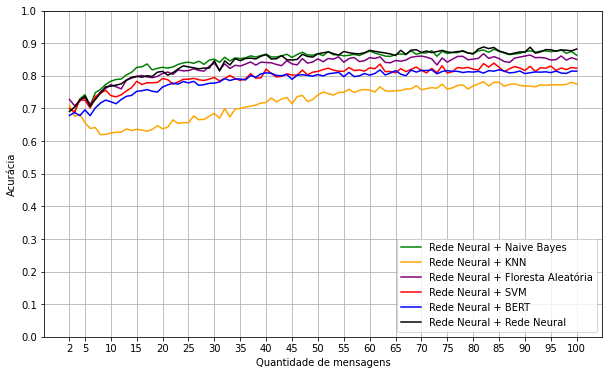

In [71]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['acc_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['acc_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['acc_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['acc_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['acc_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['acc_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

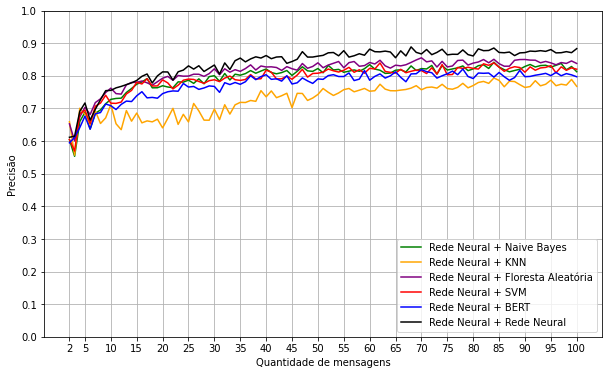

In [72]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['precision_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['precision_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['precision_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['precision_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['precision_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['precision_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

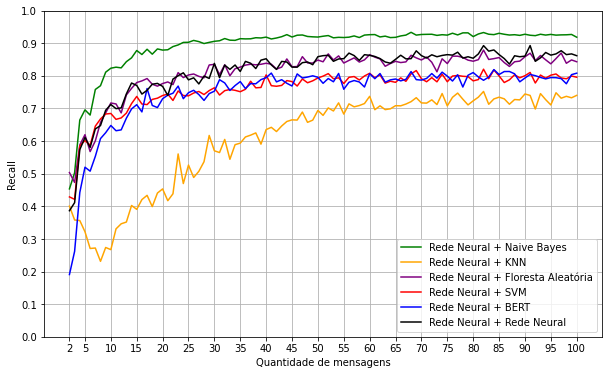

In [73]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['recall_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['recall_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['recall_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['recall_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['recall_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['recall_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

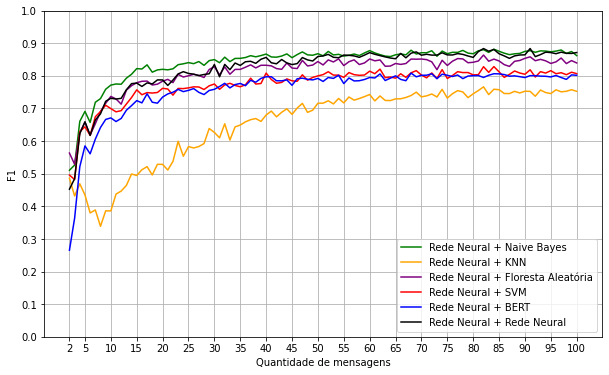

In [74]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f1_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f1_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f1_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f1_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f1_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f1_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

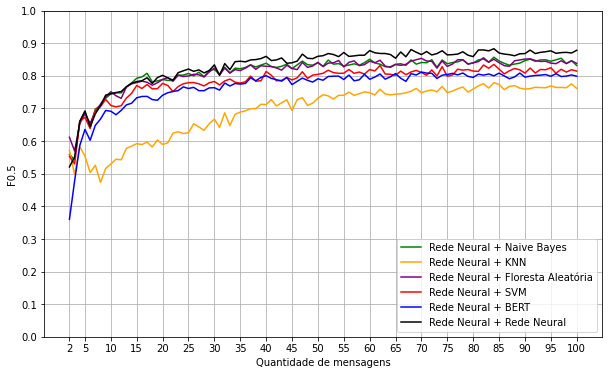

In [75]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f0_5_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f0_5_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f0_5_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f0_5_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f0_5_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f0_5_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')

#### Test

**Import preprocessed test dataset**

In [ ]:
dfTestBaseStep1 = pd.read_csv(DRIVE_PATH + 'databases/test_predatoryconversations_preprocessed.csv', sep=';', na_filter=False)

# Saving dataframe in SQLite database
dfTestBaseStep1.to_sql('conversations_step1_test', connection, if_exists='replace', index=False)

In [ ]:
dfTestBaseStep2 = pd.read_csv(DRIVE_PATH + 'databases/test_predators_preprocessed.csv', sep=';', na_filter=False)

# Saving dataframe in SQLite database
dfTestBaseStep2.to_sql('conversations_step2_test', connection, if_exists='replace', index=False)

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNN = dict()
metricsNN['acc_list'] = []
metricsNN['precision_list'] = []
metricsNN['recall_list'] = []
metricsNN['f1_list'] = []
metricsNN['f0_5_list'] = []
metricsNN['total_predators_tuples'] = []
metricsNN['predators'] = []
metricsNN['identified_predators_tuples'] = []
metricsNN['correct_predators_tuples'] = []
metricsNN['total_predators'] = []
metricsNN['correct_predators'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  predatoryConversations = []

  # Recovering test base data
  dfTestBaseStep2.to_sql('conversations_step2_test', connection, if_exists='replace', index=False)

  ####################################### STEP 1 #######################################

  ############################ TRAIN ############################

  # Group messages
  dfGroupedMessagesStep1 = groupMessagesByConversations(connection, dfBaseStep1, i)
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id, count_authors FROM conversations_grouped_step1 WHERE count_authors <> 2 ORDER BY count_authors desc;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step1 WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step1'''
  dfGroupedMessagesStep1 = pd.read_sql(query, connection)
  dfGroupedMessagesStep1.drop('count_authors', inplace=True, axis=1)
  dfGroupedMessagesStep1.replace({'predatory_conversation': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep1['messages'] = dfGroupedMessagesStep1['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  X_train = vectorizer.fit_transform(dfGroupedMessagesStep1['messages'])
  y_train = dfGroupedMessagesStep1['predatory_conversation']

  ############################ TEST ############################

  # Group messages
  dfTestGroupedMessagesStep1 = groupMessagesByConversations(connection, dfTestBaseStep1, i)
  dfTestGroupedMessagesStep1.to_sql('conversations_grouped_step1_test', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id, count_authors FROM conversations_grouped_step1_test WHERE count_authors <> 2 ORDER BY count_authors desc;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step1_test WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step1_test'''
  dfTestGroupedMessagesStep1 = pd.read_sql(query, connection)
  dfTestGroupedMessagesStep1.drop('count_authors', inplace=True, axis=1)
  dfTestGroupedMessagesStep1.replace({'predatory_conversation': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfTestGroupedMessagesStep1['messages'] = dfTestGroupedMessagesStep1['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfTestGroupedMessagesStep1.to_sql('conversations_grouped_step1_test', connection, if_exists='replace', index=False)

  # Bag of Words
  X_test = vectorizer.transform(dfTestGroupedMessagesStep1['messages'])
  y_test = dfTestGroupedMessagesStep1['predatory_conversation']

  # Neural Network MLP
  _, _, predatoryConversationsNN = callTestClassifierStep1('neural_network_mlp', dfTestGroupedMessagesStep1, X_train, y_train, X_test, y_test, i)


  ####################################### STEP 2 #######################################

  # Choosing the best result from step 1
  predatoryConversations = predatoryConversationsNN

  ############################ TRAIN ############################

  # Group messages
  dfGroupedMessagesStep2 = groupMessagesByAuthor(connection, dfBaseStep2, i)
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped_step2 GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step2 WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step2'''
  dfGroupedMessagesStep2 = pd.read_sql(query, connection)
  dfGroupedMessagesStep2.replace({'predator': {0: False, 1: True}}, inplace=True)

  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep2['messages'] = dfGroupedMessagesStep2['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)
  
  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  X_train = vectorizer.fit_transform(dfGroupedMessagesStep2['messages'])
  y_train = dfGroupedMessagesStep2['predator']

  ############################ TEST ############################

  # Deleting conversations that were not classified as predatory by step 1
  query = '''DELETE FROM conversations_step2_test WHERE conversation_id not in (%s)''' % ','.join('?'*len(predatoryConversations))
  c = connection.cursor()
  c.execute(query, (predatoryConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_step2_test'''
  dfTestConversationsStep2 = pd.read_sql(query, connection)

  # Group messages
  dfTestGroupedMessagesStep2 = groupMessagesByAuthor(connection, dfTestConversationsStep2, i)
  dfTestGroupedMessagesStep2.to_sql('conversations_grouped_step2_test', connection, if_exists='replace', index=False)

  # Remove repeated words in sequence after grouping
  dfTestGroupedMessagesStep2['messages'] = dfTestGroupedMessagesStep2['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfTestGroupedMessagesStep2.to_sql('conversations_grouped_step2_test', connection, if_exists='replace', index=False)
  
  # Bag of Words
  X_test = vectorizer.transform(dfTestGroupedMessagesStep2['messages'])
  y_test = dfTestGroupedMessagesStep2['predator']
  
  # Neural Network MLP
  indexesNN, metrics, predatorsNN = callTestClassifierStep2('neural_network_mlp', dfTestGroupedMessagesStep2, X_train, y_train, X_test, y_test, i)
  metricsNN['acc_list'].append(metrics['accuracy'])
  metricsNN['precision_list'].append(metrics['precision'])
  metricsNN['recall_list'].append(metrics['recall'])
  metricsNN['f1_list'].append(metrics['f1'])
  metricsNN['f0_5_list'].append(metrics['f0_5'])

  # total number of predators tuples
  metricsNN['total_predators_tuples'].append(len(y_test[y_test == True]))

  # number of identified predators
  metricsNN['identified_predators_tuples'].append(len(predatorsNN))
  metricsNN['predators'].append(predatorsNN)

  # number of correctly identified predators
  correct_predators_tuples = dfTestGroupedMessagesStep2[dfTestGroupedMessagesStep2.index.isin(indexesNN) & dfTestGroupedMessagesStep2['predator'] == True]
  metricsNN['correct_predators_tuples'].append(len(correct_predators_tuples))

  # total number of predators
  total_predators = dfTestGroupedMessagesStep2[dfTestGroupedMessagesStep2['predator'] == True]['author'].unique()
  metricsNN['total_predators'].append(len(total_predators))

  # number of correctly identified predators
  correct_predators = dfTestGroupedMessagesStep2[dfTestGroupedMessagesStep2.index.isin(indexesNN) & dfTestGroupedMessagesStep2['predator'] == True]['author'].unique()
  metricsNN['correct_predators'].append(len(correct_predators))

  del metrics


# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNN = {}\n'.format(metricsNN))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Predator (tuples)**

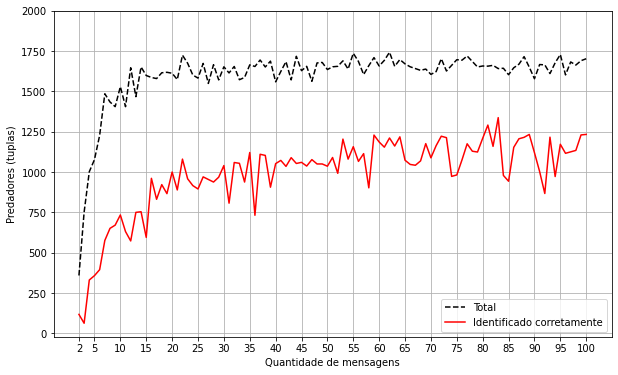

In [85]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['total_predators_tuples'], color='black', label='Total', linestyle='--')
# plt.plot(messages, metricsNN['identified_predators_tuples'], color='blue', label='Identificado', marker=marker, markerfacecolor='blue', markersize=markersize)
plt.plot(messages, metricsNN['correct_predators_tuples'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredatorsTuples)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores (tuplas)')
plt.grid(True)
plt.legend(loc='lower right')

**Predators**

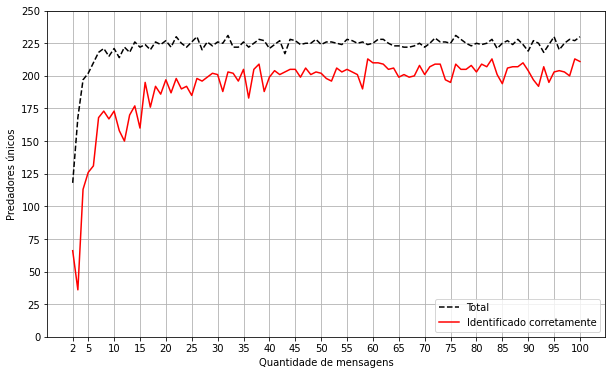

In [86]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['total_predators'], color='black', label='Total', linestyle='--')
plt.plot(messages, metricsNN['correct_predators'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredators)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores únicos')
plt.grid(True)
plt.legend(loc='lower right')

**Accuracy**

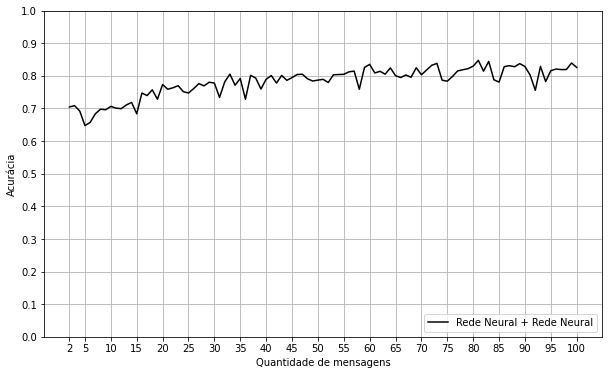

In [80]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['acc_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

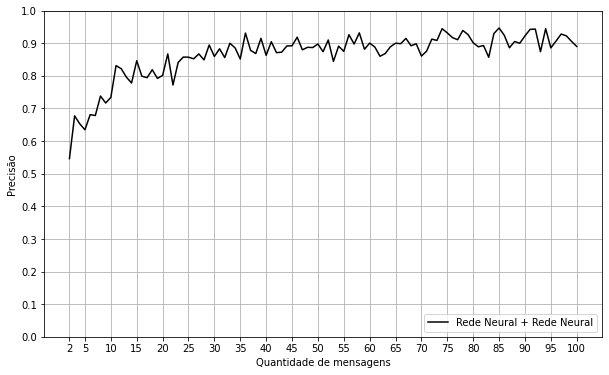

In [81]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['precision_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

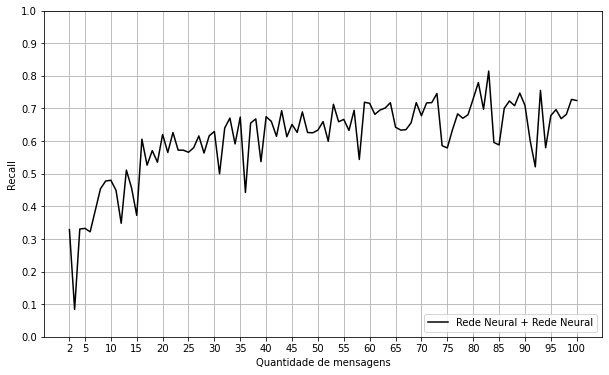

In [82]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['recall_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

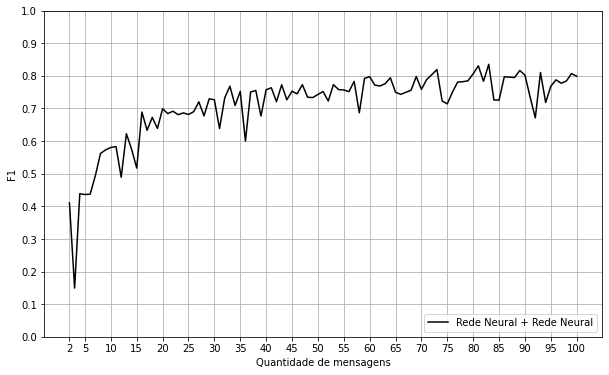

In [83]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['f1_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

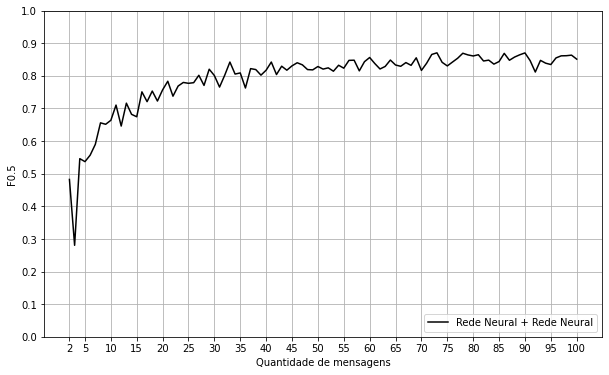

In [84]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['f0_5_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')

### Balanced classification

#### Training

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNBM = dict()
metricsNBM['acc_list'] = []
metricsNBM['precision_list'] = []
metricsNBM['recall_list'] = []
metricsNBM['f1_list'] = []
metricsNBM['f0_5_list'] = []

metricsRF = dict()
metricsRF['acc_list'] = []
metricsRF['precision_list'] = []
metricsRF['recall_list'] = []
metricsRF['f1_list'] = []
metricsRF['f0_5_list'] = []

metricsKNN = dict()
metricsKNN['acc_list'] = []
metricsKNN['precision_list'] = []
metricsKNN['recall_list'] = []
metricsKNN['f1_list'] = []
metricsKNN['f0_5_list'] = []

metricsSVM = dict()
metricsSVM['acc_list'] = []
metricsSVM['precision_list'] = []
metricsSVM['recall_list'] = []
metricsSVM['f1_list'] = []
metricsSVM['f0_5_list'] = []

metricsNN = dict()
metricsNN['acc_list'] = []
metricsNN['precision_list'] = []
metricsNN['recall_list'] = []
metricsNN['f1_list'] = []
metricsNN['f0_5_list'] = []

metricsBERT = dict()
metricsBERT['loss_list'] = []
metricsBERT['best_epochs_list'] = []
metricsBERT['acc_list'] = []
metricsBERT['precision_list'] = []
metricsBERT['recall_list'] = []
metricsBERT['f1_list'] = []
metricsBERT['f0_5_list'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  predatoryConversations = []

  # Recovering training base data
  dfBaseStep2.to_sql('conversations_step2', connection, if_exists='replace', index=False)

  ####################################### STEP 1 #######################################

  # Group messages
  dfGroupedMessagesStep1 = groupMessagesByConversations(connection, dfBaseStep1, i)
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id, count_authors FROM conversations_grouped_step1 WHERE count_authors <> 2 ORDER BY count_authors desc;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step1 WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step1'''
  dfGroupedMessagesStep1 = pd.read_sql(query, connection)
  dfGroupedMessagesStep1.drop('count_authors', inplace=True, axis=1)
  dfGroupedMessagesStep1.replace({'predatory_conversation': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep1['messages'] = dfGroupedMessagesStep1['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  bagofwords = vectorizer.fit_transform(dfGroupedMessagesStep1['messages'])
  X = bagofwords
  y = dfGroupedMessagesStep1['predatory_conversation']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X, y = nm.fit_resample(X, y)

  # Neural Network MLP
  _, _, predatoryConversationsNN = callClassifierStep1('neural_network_mlp', dfGroupedMessagesStep1, X, y, i, nm.sample_indices_)

  ####################################### STEP 2 #######################################

  # Choosing the best result from step 1
  predatoryConversations = predatoryConversationsNN

  # Deleting conversations that were not classified as predatory by step 1
  query = '''DELETE FROM conversations_step2 WHERE conversation_id not in (%s)''' % ','.join('?'*len(predatoryConversations))
  c = connection.cursor()
  c.execute(query, (predatoryConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_step2'''
  dfConversationsStep2 = pd.read_sql(query, connection)

  # Group messages
  dfGroupedMessagesStep2 = groupMessagesByAuthor(connection, dfConversationsStep2, i)
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)

  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep2['messages'] = dfGroupedMessagesStep2['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)
  
  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  bagofwords = vectorizer.fit_transform(dfGroupedMessagesStep2['messages'])
  X = bagofwords
  y = dfGroupedMessagesStep2['predator']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X, y = nm.fit_resample(X, y)

  # Naive Bayes Multinomial
  _, metrics, predatoryConversationsNBM = callClassifierStep2('naive_bayes_multinomial', dfGroupedMessagesStep2, X, y, i, nm.sample_indices_)
  metricsNBM['acc_list'].append(metrics['accuracy_avg'])
  metricsNBM['precision_list'].append(metrics['precision_avg'])
  metricsNBM['recall_list'].append(metrics['recall_avg'])
  metricsNBM['f1_list'].append(metrics['f1_avg'])
  metricsNBM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # Random Forest
  _, metrics, predatoryConversationsRF = callClassifierStep2('random_forest', dfGroupedMessagesStep2, X, y, i, nm.sample_indices_)
  metricsRF['acc_list'].append(metrics['accuracy_avg'])
  metricsRF['precision_list'].append(metrics['precision_avg'])
  metricsRF['recall_list'].append(metrics['recall_avg'])
  metricsRF['f1_list'].append(metrics['f1_avg'])
  metricsRF['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # KNN
  _, metrics, predatoryConversationsKNN = callClassifierStep2('knn', dfGroupedMessagesStep2, X, y, i, nm.sample_indices_)
  metricsKNN['acc_list'].append(metrics['accuracy_avg'])
  metricsKNN['precision_list'].append(metrics['precision_avg'])
  metricsKNN['recall_list'].append(metrics['recall_avg'])
  metricsKNN['f1_list'].append(metrics['f1_avg'])
  metricsKNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # SVM
  _, metrics, predatoryConversationsSVM = callClassifierStep2('svm', dfGroupedMessagesStep2, X, y, i, nm.sample_indices_)
  metricsSVM['acc_list'].append(metrics['accuracy_avg'])
  metricsSVM['precision_list'].append(metrics['precision_avg'])
  metricsSVM['recall_list'].append(metrics['recall_avg'])
  metricsSVM['f1_list'].append(metrics['f1_avg'])
  metricsSVM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics
  
  # Neural Network MLP
  _, metrics, predatoryConversationsNN = callClassifierStep2('neural_network_mlp', dfGroupedMessagesStep2, X, y, i, nm.sample_indices_)
  metricsNN['acc_list'].append(metrics['accuracy_avg'])
  metricsNN['precision_list'].append(metrics['precision_avg'])
  metricsNN['recall_list'].append(metrics['recall_avg'])
  metricsNN['f1_list'].append(metrics['f1_avg'])
  metricsNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # BERT
  tokens = tokenizeMessagesBERT(dfGroupedMessagesStep2['messages'])
  embeddings = generateEmbeddingsBERT(tokens)
  dfEmbeddingsBERT = pd.DataFrame(embeddings)
  X = dfEmbeddingsBERT
  y = dfGroupedMessagesStep2['predator']
  # Balancing classes - Undersampling
  nm = NearMiss()
  X, y = nm.fit_resample(X, y)
  epochs = 50
  batch_size = 32
  _, metrics, predatoryConversationsBERT = callClassifierStep2('bert', dfGroupedMessagesStep2, X.values, y.values, i, nm.sample_indices_, n_splits, device, epochs, batch_size)
  metricsBERT['loss_list'].append(metrics['loss_avg'])
  metricsBERT['best_epochs_list'].append(metrics['best_epochs'])  
  metricsBERT['acc_list'].append(metrics['accuracy_avg'])
  metricsBERT['precision_list'].append(metrics['precision_avg'])
  metricsBERT['recall_list'].append(metrics['recall_avg'])
  metricsBERT['f1_list'].append(metrics['f1_avg'])
  metricsBERT['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics


# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNBM = {}\n'.format(metricsNBM))
f.write('metricsRF = {}\n'.format(metricsRF))
f.write('metricsKNN = {}\n'.format(metricsKNN))
f.write('metricsSVM = {}\n'.format(metricsSVM))
f.write('metricsNN = {}\n'.format(metricsNN))
f.write('metricsBERT = {}\n'.format(metricsBERT))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Accuracy**

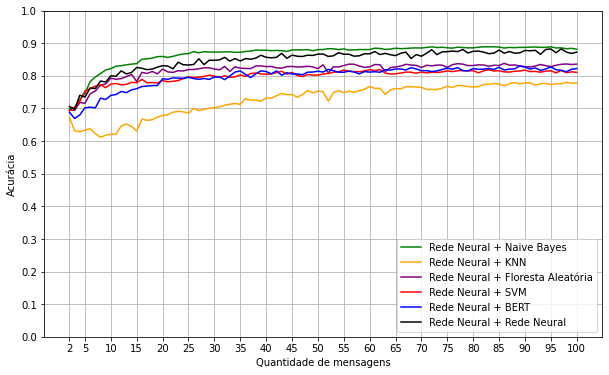

In [88]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['acc_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['acc_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['acc_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['acc_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['acc_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['acc_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

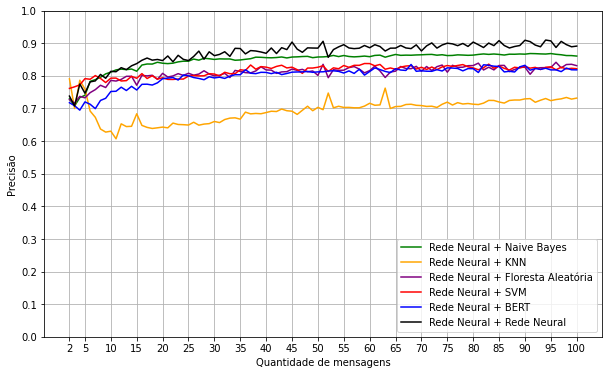

In [89]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['precision_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['precision_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['precision_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['precision_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['precision_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['precision_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

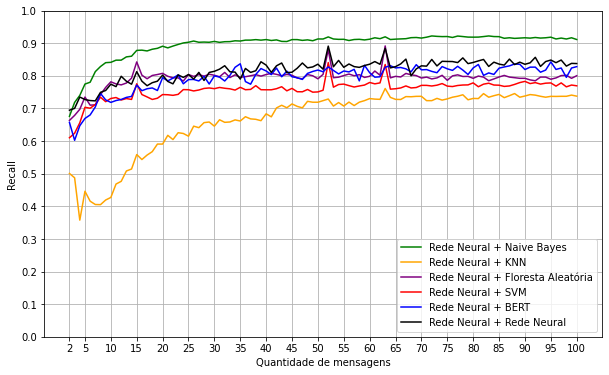

In [90]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['recall_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['recall_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['recall_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['recall_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['recall_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['recall_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

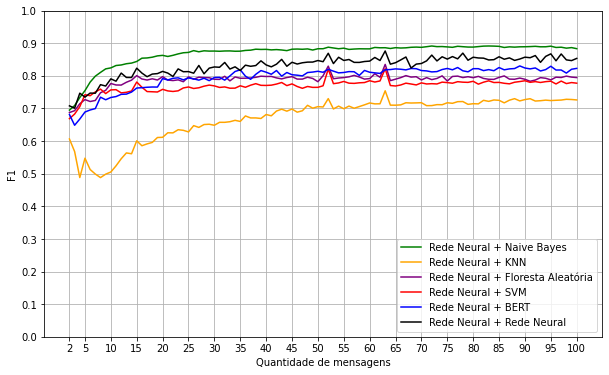

In [91]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f1_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f1_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f1_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f1_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f1_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f1_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

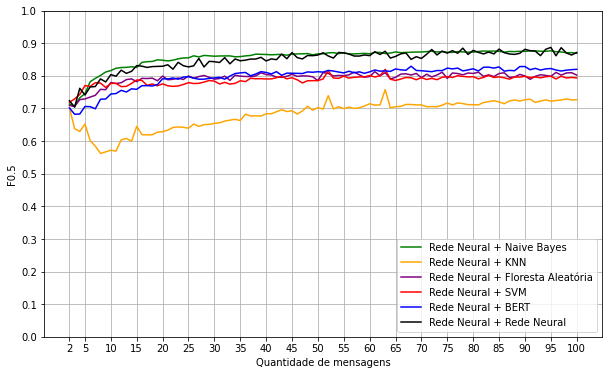

In [92]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f0_5_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f0_5_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f0_5_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f0_5_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f0_5_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f0_5_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')

#### Test

**Import preprocessed test dataset**

In [ ]:
dfTestBaseStep1 = pd.read_csv(DRIVE_PATH + 'databases/test_predatoryconversations_preprocessed.csv', sep=';', na_filter=False)

# Saving dataframe in SQLite database
dfTestBaseStep1.to_sql('conversations_step1_test', connection, if_exists='replace', index=False)

In [ ]:
dfTestBaseStep2 = pd.read_csv(DRIVE_PATH + 'databases/test_predators_preprocessed.csv', sep=';', na_filter=False)

# Saving dataframe in SQLite database
dfTestBaseStep2.to_sql('conversations_step2_test', connection, if_exists='replace', index=False)

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNBM = dict()
metricsNBM['acc_list'] = []
metricsNBM['precision_list'] = []
metricsNBM['recall_list'] = []
metricsNBM['f1_list'] = []
metricsNBM['f0_5_list'] = []
metricsNBM['total_predators_tuples'] = []
metricsNBM['predators'] = []
metricsNBM['identified_predators_tuples'] = []
metricsNBM['correct_predators_tuples'] = []
metricsNBM['total_predators'] = []
metricsNBM['correct_predators'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  predatoryConversations = []

  # Recovering test base data
  dfTestBaseStep2.to_sql('conversations_step2_test', connection, if_exists='replace', index=False)

  ####################################### STEP 1 #######################################

  ############################ TRAIN ############################

  # Group messages
  dfGroupedMessagesStep1 = groupMessagesByConversations(connection, dfBaseStep1, i)
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id, count_authors FROM conversations_grouped_step1 WHERE count_authors <> 2 ORDER BY count_authors desc;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step1 WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step1'''
  dfGroupedMessagesStep1 = pd.read_sql(query, connection)
  dfGroupedMessagesStep1.drop('count_authors', inplace=True, axis=1)
  dfGroupedMessagesStep1.replace({'predatory_conversation': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep1['messages'] = dfGroupedMessagesStep1['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep1.to_sql('conversations_grouped_step1', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  X_train = vectorizer.fit_transform(dfGroupedMessagesStep1['messages'])
  y_train = dfGroupedMessagesStep1['predatory_conversation']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X_train, y_train = nm.fit_resample(X_train, y_train)

  ############################ TEST ############################

  # Group messages
  dfTestGroupedMessagesStep1 = groupMessagesByConversations(connection, dfTestBaseStep1, i)
  dfTestGroupedMessagesStep1.to_sql('conversations_grouped_step1_test', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id, count_authors FROM conversations_grouped_step1_test WHERE count_authors <> 2 ORDER BY count_authors desc;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step1_test WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step1_test'''
  dfTestGroupedMessagesStep1 = pd.read_sql(query, connection)
  dfTestGroupedMessagesStep1.drop('count_authors', inplace=True, axis=1)
  dfTestGroupedMessagesStep1.replace({'predatory_conversation': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfTestGroupedMessagesStep1['messages'] = dfTestGroupedMessagesStep1['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfTestGroupedMessagesStep1.to_sql('conversations_grouped_step1_test', connection, if_exists='replace', index=False)

  # Bag of Words
  X_test = vectorizer.transform(dfTestGroupedMessagesStep1['messages'])
  y_test = dfTestGroupedMessagesStep1['predatory_conversation']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X_test, y_test = nm.fit_resample(X_test, y_test)

  # Neural Network MLP
  _, _, predatoryConversationsNN = callTestClassifierStep1('neural_network_mlp', dfTestGroupedMessagesStep1, X_train, y_train, X_test, y_test, i, nm.sample_indices_)


  ####################################### STEP 2 #######################################

  # Choosing the best result from step 1
  predatoryConversations = predatoryConversationsNN

  ############################ TRAIN ############################

  # Group messages
  dfGroupedMessagesStep2 = groupMessagesByAuthor(connection, dfBaseStep2, i)
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped_step2 GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_step2 WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_step2'''
  dfGroupedMessagesStep2 = pd.read_sql(query, connection)
  dfGroupedMessagesStep2.replace({'predator': {0: False, 1: True}}, inplace=True)

  # Remove repeated words in sequence after grouping
  dfGroupedMessagesStep2['messages'] = dfGroupedMessagesStep2['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessagesStep2.to_sql('conversations_grouped_step2', connection, if_exists='replace', index=False)
  
  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  X_train = vectorizer.fit_transform(dfGroupedMessagesStep2['messages'])
  y_train = dfGroupedMessagesStep2['predator']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X_train, y_train = nm.fit_resample(X_train, y_train)

  ############################ TEST ############################

  # Deleting conversations that were not classified as predatory by step 1
  query = '''DELETE FROM conversations_step2_test WHERE conversation_id not in (%s)''' % ','.join('?'*len(predatoryConversations))
  c = connection.cursor()
  c.execute(query, (predatoryConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_step2_test'''
  dfTestConversationsStep2 = pd.read_sql(query, connection)

  # Group messages
  dfTestGroupedMessagesStep2 = groupMessagesByAuthor(connection, dfTestConversationsStep2, i)
  dfTestGroupedMessagesStep2.to_sql('conversations_grouped_step2_test', connection, if_exists='replace', index=False)

  # Remove repeated words in sequence after grouping
  dfTestGroupedMessagesStep2['messages'] = dfTestGroupedMessagesStep2['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfTestGroupedMessagesStep2.to_sql('conversations_grouped_step2_test', connection, if_exists='replace', index=False)
  
  # Bag of Words
  X_test = vectorizer.transform(dfTestGroupedMessagesStep2['messages'])
  y_test = dfTestGroupedMessagesStep2['predator']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X_test, y_test = nm.fit_resample(X_test, y_test)

  # Naive Bayes Multinomial
  indexesNBM, metrics, predatorsNBM = callTestClassifierStep2('naive_bayes_multinomial', dfTestGroupedMessagesStep2, X_train, y_train, X_test, y_test, i, nm.sample_indices_)
  metricsNBM['acc_list'].append(metrics['accuracy'])
  metricsNBM['precision_list'].append(metrics['precision'])
  metricsNBM['recall_list'].append(metrics['recall'])
  metricsNBM['f1_list'].append(metrics['f1'])
  metricsNBM['f0_5_list'].append(metrics['f0_5'])

  # total number of predators tuples
  metricsNBM['total_predators_tuples'].append(len(y_test[y_test == True]))

  # number of identified predators
  metricsNBM['identified_predators_tuples'].append(len(predatorsNBM))
  metricsNBM['predators'].append(predatorsNBM)

  # number of correctly identified predators
  correct_predators_tuples = dfTestGroupedMessagesStep2[dfTestGroupedMessagesStep2.index.isin(nm.sample_indices_[indexesNBM]) & dfTestGroupedMessagesStep2['predator'] == True]
  metricsNBM['correct_predators_tuples'].append(len(correct_predators_tuples))

  # total number of predators
  total_predators = dfTestGroupedMessagesStep2[dfTestGroupedMessagesStep2['predator'] == True]['author'].unique()
  metricsNBM['total_predators'].append(len(total_predators))

  # number of correctly identified predators
  correct_predators = dfTestGroupedMessagesStep2[dfTestGroupedMessagesStep2.index.isin(nm.sample_indices_[indexesNBM]) & dfTestGroupedMessagesStep2['predator'] == True]['author'].unique()
  metricsNBM['correct_predators'].append(len(correct_predators))

  del metrics


# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNBM = {}\n'.format(metricsNBM))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Predator (tuples)**

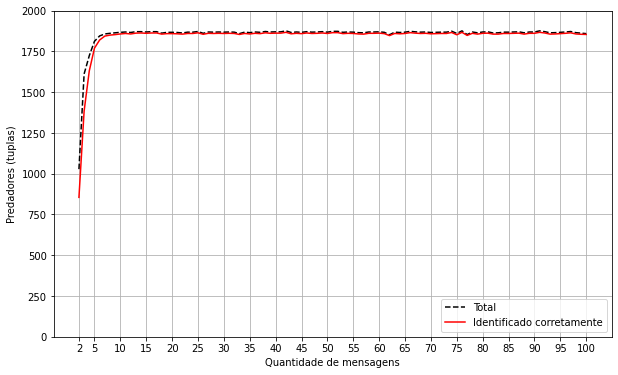

In [95]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['total_predators_tuples'], color='black', label='Total', linestyle='--')
# plt.plot(messages, metricsNBM['identified_predators_tuples'], color='blue', label='Identificado', marker=marker, markerfacecolor='blue', markersize=markersize)
plt.plot(messages, metricsNBM['correct_predators_tuples'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredatorsTuples)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores (tuplas)')
plt.grid(True)
plt.legend(loc='lower right')

**Predators**

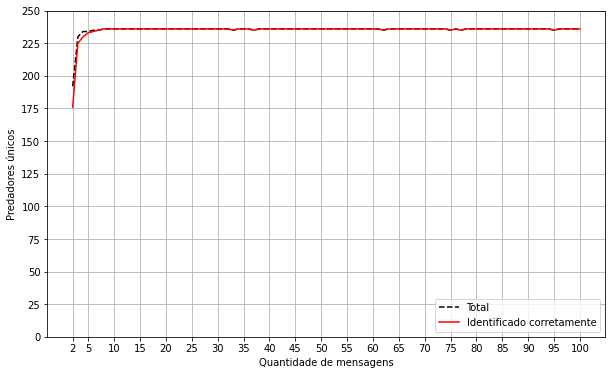

In [96]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['total_predators'], color='black', label='Total', linestyle='--')
plt.plot(messages, metricsNBM['correct_predators'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredators)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores únicos')
plt.grid(True)
plt.legend(loc='lower right')

**Accuracy**

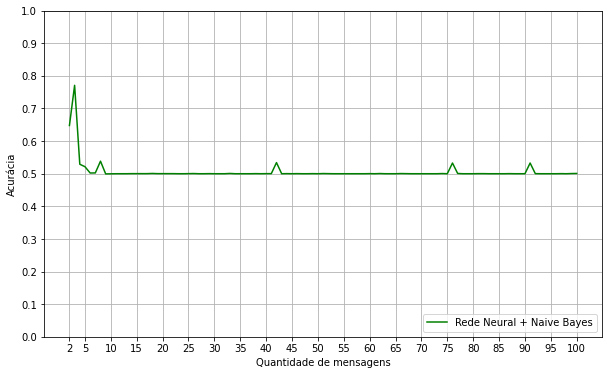

In [97]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['acc_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

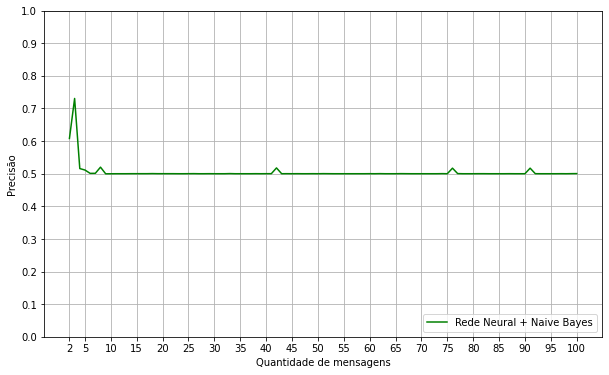

In [98]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['precision_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

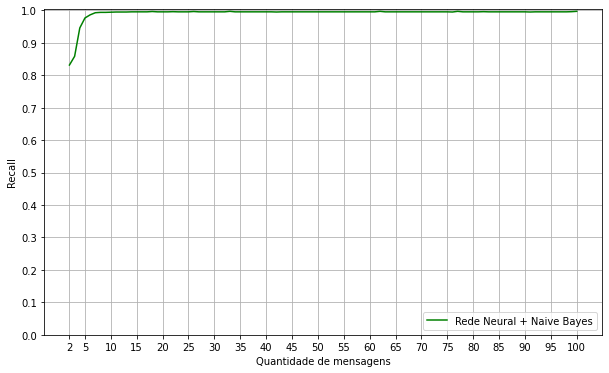

In [99]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['recall_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

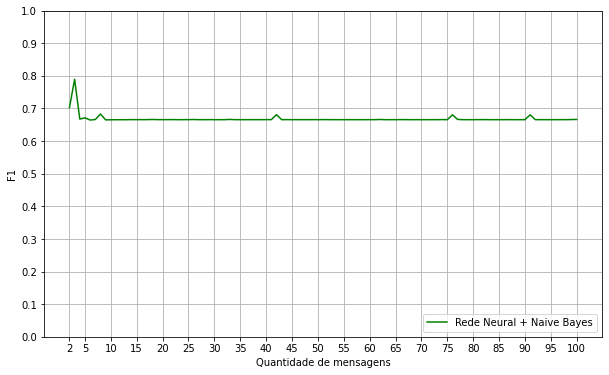

In [100]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f1_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

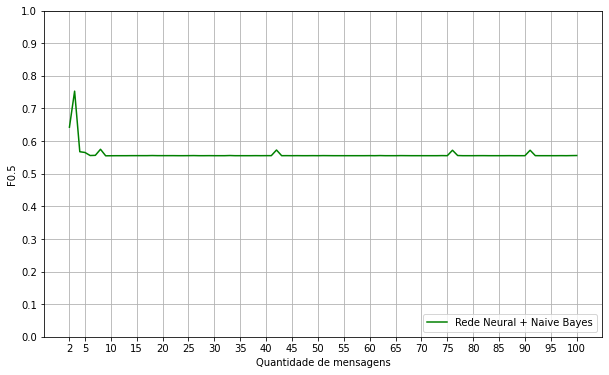

In [101]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f0_5_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')